# Comprehensive Contrastive Representation Distillation - CIFAR-100
## Full Analysis: SupCon vs SupCRD vs Balanced vs Hybrid

**Goal**: Comprehensive evaluation of contrastive distillation methods on CIFAR-100 with:
- α/β hyperparameter sweeps
- Temperature analysis
- Balanced force normalization
- Pull/push force dynamics
- Semantic similarity validation
- Hybrid loss optimization
- **Switchable architectures**: ConvNet vs ResNet-18

**Methods**:
- **Baseline SupCon**: Standard supervised contrastive learning
- **SupCRD**: Logit-weighted representation distillation (α, β tuning)
- **Balanced SupCRD**: Force-normalized variant
- **Hybrid**: Combined SupCon + SupCRD (λ tuning)

---
## Setup & Imports

In [1]:

import json
import os
import random
import warnings

import detectors  # it may not be used directly but timm needs it
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from scipy.stats import gaussian_kde
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader

os.environ["TQDM_NOTEBOOK"] = "0"
from tqdm import tqdm

# Create directories
os.makedirs("plots", exist_ok=True)
os.makedirs("pth_models", exist_ok=True)
os.makedirs("json_results", exist_ok=True)
os.makedirs("json_results/training_logs", exist_ok=True)
print("✓ Created directories: plots/, pth_models/, json_results/")

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)
print(f"Random seed set to 42 for reproducibility")

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
warnings.filterwarnings("ignore", category=RuntimeWarning, module="threadpoolctl")

/venv/main/lib/python3.12/site-packages/outdated/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


✓ Created directories: plots/, pth_models/, json_results/
Using device: cuda
Random seed set to 42 for reproducibility


---
## Architecture Selection & Hyperparameters

**KEY CONFIGURATION**: Set your architecture choice here

In [2]:
# ============================================================
# ARCHITECTURE SELECTION (CHANGE HERE)
# ============================================================
TEACHER_ARCH = "resnet50"  # Options: "convnet" or "resnet50"
STUDENT_ARCH = "resnet18"  # Options: "convnet" or "resnet18"

# ============================================================
# TRAINING CONFIGURATION
# ============================================================
BATCH_SIZE = 128
LR = 1e-3

# Epoch settings (adjust based on architecture)
if TEACHER_ARCH == "resnet50" or TEACHER_ARCH == "resnet18":
    EPOCHS_TEACHER = 50
    EPOCHS_STUDENT = 50
    USE_LR_SCHEDULER = True
else:
    EPOCHS_TEACHER = 20  # ConvNet
    EPOCHS_STUDENT = 40
    USE_LR_SCHEDULER = False

# ============================================================
# CONTRASTIVE & DISTILLATION CONFIG
# ============================================================
TEMP = 0.07
ALPHA = 1.0
BETA = 10.0

# Sweep ranges (reduced for faster iteration)
ALPHA_SWEEP = [1.0, 2.0]  # Reduced from [1, 2, 3, 4, 5, 10, 50]
BETA_SWEEP = [1.0, 10.0]  # Reduced from [1, 10, 12, 20, 50]
TEMP_SWEEP = [0.05, 0.07]  # Reduced from [0.05, 0.07, 0.1, 0.15]
LAMBDA_SWEEP = [0.3, 0.5, 0.7, 0.9]

# ============================================================
# DATASET CONFIG (CIFAR-100)
# ============================================================
num_classes = 100

# CIFAR-100 superclass mapping (20 superclasses, 5 classes each)
cifar100_superclasses = [
    "aquatic_mammals",
    "fish",
    "flowers",
    "food_containers",
    "fruit_vegetables",
    "household_electrical",
    "household_furniture",
    "insects",
    "large_carnivores",
    "large_omnivores",
    "medium_mammals",
    "non-insect_invertebrates",
    "people",
    "reptiles",
    "small_mammals",
    "trees",
    "vehicles_1",
    "vehicles_2",
]

# Sample classes for visualization (not all 100)
sample_classes = list(range(20))

print(f"\n{'='*60}")
print(f"CONFIGURATION SUMMARY")
print(f"{'='*60}")
print(f"Teacher Architecture: {TEACHER_ARCH.upper()}")
print(f"Student Architecture: {STUDENT_ARCH.upper()}")
print(f"Dataset: CIFAR-100 ({num_classes} classes)")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LR}")
print(f"Teacher Epochs: {EPOCHS_TEACHER}")
print(f"Student Epochs: {EPOCHS_STUDENT}")
print(f"LR Scheduler: {USE_LR_SCHEDULER}")
print(f"Temperature: {TEMP}")
print(f"Training Mode: Multi-view (2 augmented views per sample)")
print(f"Alpha Sweep: {ALPHA_SWEEP}")
print(f"Beta Sweep: {BETA_SWEEP}")
print(f"Temp Sweep: {TEMP_SWEEP}")
print(f"{'='*60}\n")


class TwoViewTransform:
    """Create two augmented views of the same image"""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        view1 = self.base_transform(x)
        view2 = self.base_transform(x)
        return view1, view2


CONFIGURATION SUMMARY
Teacher Architecture: RESNET50
Student Architecture: RESNET18
Dataset: CIFAR-100 (100 classes)
Batch Size: 128
Learning Rate: 0.001
Teacher Epochs: 50
Student Epochs: 50
LR Scheduler: True
Temperature: 0.07
Training Mode: Multi-view (2 augmented views per sample)
Alpha Sweep: [1.0, 2.0]
Beta Sweep: [1.0, 10.0]
Temp Sweep: [0.05, 0.07]



---
## Data Loading with Augmentation

In [3]:
# CIFAR-100 mean and std
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

# Base training transform with augmentation
base_transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

# Multi-view wrapper (creates 2 augmented views per sample)
transform_train_multiview = TwoViewTransform(base_transform_train)

# Test transform (no augmentation, single view)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

train_set = torchvision.datasets.CIFAR100(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform_train_multiview  # Multi-view
)
train_loader = DataLoader(
    train_set, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2,
    pin_memory=True
)

test_set = torchvision.datasets.CIFAR100(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform_test
)
test_loader = DataLoader(
    test_set, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=2,
    pin_memory=True
)

print(f"Train samples: {len(train_set)}")
print(f"Test samples: {len(test_set)}")
print(f"Training mode: Multi-view (2 augmented views per sample)")
print(f"Augmentation: RandomCrop, HFlip, ColorJitter")

Train samples: 50000
Test samples: 10000
Training mode: Multi-view (2 augmented views per sample)
Augmentation: RandomCrop, HFlip, ColorJitter


---
## Model Architecture (Switchable)

Two architecture options:
1. **ConvNet**: Fast, 3-layer CNN (same as CIFAR-10)
2. **ResNet-18**: Deeper, more capacity, slower training

In [4]:
class ConvEncoder(nn.Module):
    """Shallow 3-layer ConvNet encoder"""

    def __init__(self, feature_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.flat_dim = 128 * 4 * 4
        self.fc = nn.Linear(self.flat_dim, feature_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


class ResNetEncoder(nn.Module):
    """ResNet encoder (adapted for CIFAR)"""

    def __init__(self, feature_dim=512, arch="resnet18"):  # Add arch parameter
        super().__init__()

        # Choose architecture
        if arch == "resnet18":
            resnet = models.resnet18(weights=None)
            base_dim = 512
        elif arch == "resnet50":
            resnet = models.resnet50(weights=None)
            base_dim = 2048  # ResNet50 has 2048-dim features
        else:
            raise ValueError(f"Unknown ResNet arch: {arch}")

        # Replace first conv: kernel 7->3, stride 2->1, remove maxpool
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        # Skip maxpool for CIFAR (small images)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool

        # Project base_dim -> feature_dim if different
        if feature_dim != base_dim:
            self.projection = nn.Linear(base_dim, feature_dim)
        else:
            self.projection = nn.Identity()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.projection(x)
        return x


class ModelWrapper(nn.Module):
    """Wrapper with switchable encoder"""
    def __init__(self, num_classes=100, arch="convnet"):
        super().__init__()
        self.arch = arch
        
        if arch == "convnet":
            self.encoder = ConvEncoder(feature_dim=128)
            self.feature_dim = 128
        elif arch == "resnet18":
            self.encoder = ResNetEncoder(feature_dim=512, arch="resnet18")
            self.feature_dim = 512
        elif arch == "resnet50":
            self.encoder = ResNetEncoder(feature_dim=512, arch="resnet50")
            self.feature_dim = 512
        else:
            raise ValueError(f"Unknown architecture: {arch}")
        
        # Projector: feature_dim → 128 → 64
        self.projector = nn.Sequential(
            nn.Linear(self.feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        
        # Classifier
        self.classifier = nn.Linear(self.feature_dim, num_classes)
    
    def forward(self, x):
        feats = self.encoder(x)
        proj = self.projector(feats)
        logits = self.classifier(feats)
        return feats, proj, logits


# Test instantiation
test_teacher = ModelWrapper(num_classes=100, arch=TEACHER_ARCH).to(device)
test_student = ModelWrapper(num_classes=100, arch=STUDENT_ARCH).to(device)

print(f"✓ Model architectures defined")
print(f"  Teacher: {TEACHER_ARCH.upper()} ({test_teacher.feature_dim}-dim features)")
print(f"  Student: {STUDENT_ARCH.upper()} ({test_student.feature_dim}-dim features)")

# Count parameters
teacher_params = sum(p.numel() for p in test_teacher.parameters())
student_params = sum(p.numel() for p in test_student.parameters())
print(f"  Teacher params: {teacher_params:,}")
print(f"  Student params: {student_params:,}")

del test_teacher, test_student

✓ Model architectures defined
  Teacher: RESNET50 (512-dim features)
  Student: RESNET18 (512-dim features)
  Teacher params: 24,674,660
  Student params: 11,294,052


---
## Loss Functions

In [5]:
class SupConLoss(nn.Module):
    """Baseline Supervised Contrastive Loss"""

    def __init__(self, temperature=0.07):
        super().__init__()
        self.temp = temperature

    def forward(self, student_proj, labels):
        feats = F.normalize(student_proj, dim=1)
        sim_matrix = torch.matmul(feats, feats.T) / self.temp
        labels = labels.view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(feats.shape[0]).view(-1, 1).to(device),
            0,
        )
        mask = mask * logits_mask
        logits_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = sim_matrix - logits_max.detach()
        exp_logits = torch.exp(sim_matrix) * logits_mask
        log_prob = sim_matrix - torch.log(exp_logits.sum(1, keepdim=True))
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-8)
        return -mean_log_prob_pos.mean()


class LogitWeightedSupCRDLoss(nn.Module):
    """SupCRD with α/β weighting"""

    def __init__(self, alpha=1.0, beta=1.0, temperature=0.07, eps=1e-8):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.tau = temperature
        self.eps = eps

    def forward(self, student_features, teacher_features, teacher_logits, labels):
        batch_size = student_features.shape[0]
        device = student_features.device

        s_norm = F.normalize(student_features, dim=1)
        t_norm = F.normalize(teacher_features, dim=1)

        sim_matrix = torch.matmul(s_norm, t_norm.T) / self.tau
        sim_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = sim_matrix - sim_max.detach()
        exp_sim = torch.exp(sim_matrix)

        teacher_probs = F.softmax(teacher_logits, dim=1)
        labels = labels.view(-1, 1)
        mask_pos = torch.eq(labels, labels.T).float().to(device)
        mask_neg = 1.0 - mask_pos

        p_target = torch.gather(teacher_probs, 1, labels).view(-1)
        w_pull = self.alpha * p_target

        target_labels_expand = labels.view(1, -1).expand(batch_size, -1)
        p_negative_class = torch.gather(teacher_probs, 1, target_labels_expand)
        w_push = self.beta * (1.0 - p_negative_class)

        sum_pos_exp = (exp_sim * mask_pos).sum(dim=1)
        numerator_term = w_pull * sum_pos_exp
        weighted_neg_exp = (exp_sim * w_push * mask_neg).sum(dim=1)
        denominator_term = numerator_term + weighted_neg_exp

        loss = -torch.log((numerator_term + self.eps) / (denominator_term + self.eps))
        return loss.mean()


class HybridSupCRDLoss(nn.Module):
    """Hybrid: λ * SupCon + (1-λ) * SupCRD"""

    def __init__(self, alpha=1.0, beta=10.0, lambda_supcon=0.7, temperature=0.07):
        super().__init__()
        self.supcon_loss = SupConLoss(temperature=temperature)
        self.supcrd_loss = LogitWeightedSupCRDLoss(
            alpha=alpha, beta=beta, temperature=temperature
        )
        self.lambda_supcon = lambda_supcon
        self.register_buffer("supcon_scale", torch.tensor(1.0))
        self.register_buffer("supcrd_scale", torch.tensor(1.0))
        self.warmup_steps = 100
        self.step_count = 0

    def forward(self, student_proj, teacher_proj, teacher_logits, labels):
        loss_supcon = self.supcon_loss(student_proj, labels)
        loss_supcrd = self.supcrd_loss(
            student_proj, teacher_proj, teacher_logits, labels
        )
        if self.step_count < self.warmup_steps:
            self.step_count += 1
            with torch.no_grad():
                self.supcon_scale = 0.9 * self.supcon_scale + 0.1 * loss_supcon.detach()
                self.supcrd_scale = 0.9 * self.supcrd_scale + 0.1 * loss_supcrd.detach()
        loss_supcon_norm = loss_supcon / (self.supcon_scale + 1e-8)
        loss_supcrd_norm = loss_supcrd / (self.supcrd_scale + 1e-8)
        return (
            self.lambda_supcon * loss_supcon_norm
            + (1 - self.lambda_supcon) * loss_supcrd_norm
        )


print("✓ Loss functions defined")

✓ Loss functions defined


---
## Utility Functions

In [6]:
def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # If the model returns a tuple (feats, proj, logits), take logits
            if isinstance(output, tuple):
                output = output[2]  # logits is the 3rd element (index 2)

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100 * correct / total


def extract_features_and_labels(model, loader, device, max_samples=5000):
    """Extract features and labels for visualization. Handles models with or without projection."""
    model.eval()
    features_list = []
    labels_list = []
    count = 0
    
    with torch.no_grad():
        for images, labels in loader:
            if count >= max_samples:
                break
            images = images.to(device)
            
            # Handle different model types
            if hasattr(model, "encoder"):  # ModelWrapper
                features = model.encoder(images)
                proj = model.projector(features)
            else:  # timm model
                if hasattr(model, "fc"):
                    original_fc = model.fc
                    model.fc = nn.Identity()
                    features = model(images)
                    model.fc = original_fc
                elif hasattr(model, "classifier"):
                    original_classifier = model.classifier
                    model.classifier = nn.Identity()
                    features = model(images)
                    model.classifier = original_classifier
                else:
                    features = model(images)
                
                if hasattr(model, "projection"):
                    proj = model.projection(features)
                else:
                    proj = features  # Use raw features
            
            features_list.append(proj.cpu().numpy())
            labels_list.append(labels.numpy())
            count += images.size(0)
    
    features = np.concatenate(features_list, axis=0)[:max_samples]
    labels = np.concatenate(labels_list, axis=0)[:max_samples]
    return features, labels


def visualize_latents(
    model, loader, device, title="", sample_classes=None, max_samples=5000
):
    """Visualize latent space with t-SNE (sample subset for CIFAR-100)."""
    features, labels = extract_features_and_labels(model, loader, device, max_samples)

    # If sample_classes specified, only visualize those
    if sample_classes is not None:
        mask = np.isin(labels, sample_classes)
        features = features[mask]
        labels = labels[mask]
        print(f"  Visualizing {len(sample_classes)} classes, {len(features)} samples")

    print(f"  Running t-SNE on {len(features)} samples...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features) - 1))
    embedded = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(labels)

    for label in unique_labels:
        mask = labels == label
        plt.scatter(
            embedded[mask, 0],
            embedded[mask, 1],
            label=f"Class {label}",
            alpha=0.6,
            s=20,
        )

    plt.title(f"t-SNE: {title}", fontsize=14, fontweight="bold")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    if len(unique_labels) <= 20:
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
    plt.tight_layout()

    safe_title = title.replace(" ", "_").replace("/", "_")
    # Ensure plots directory exists
    os.makedirs("plots", exist_ok=True)
    plt.savefig(f"plots/tsne_{safe_title}.png", dpi=150, bbox_inches="tight")
    plt.show()


def visualize_alignment_uniformity(
    model, test_loader, device, title="Model", save_path=None
):
    """
    Visualize alignment and uniformity following Wang & Isola 2020.
    Creates the same plots as "Understanding Contrastive Representation Learning"
    Handles models with or without projection heads.
    """
    model.eval()
    # Collect projections and labels
    all_projections = []
    all_labels = []
    print("Extracting projections for alignment/uniformity analysis...")
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Extracting"):
            images = images.to(device)

            # Check if model is our custom ModelWrapper or a standard timm model
            if hasattr(model, "encoder"):  # ModelWrapper (Student)
                features = model.encoder(images)
                proj = model.projector(features)
                proj = F.normalize(proj, dim=1)

            else:  # timm/torchvision model (Teacher)
                # Get features by stripping the fc layer temporarily
                if hasattr(model, "fc"):
                    original_fc = model.fc
                    model.fc = nn.Identity()
                    features = model(images)
                    model.fc = original_fc
                elif hasattr(model, "classifier"):
                    original_classifier = model.classifier
                    model.classifier = nn.Identity()
                    features = model(images)
                    model.classifier = original_classifier
                else:
                    features = model(images)

                # Get projections (either trained or use raw features)
                if hasattr(model, "projection"):
                    proj = model.projection(features)
                else:
                    # Use raw features (e.g., 2048-dim)
                    proj = features

                proj = F.normalize(proj, dim=1)

            all_projections.append(proj.cpu())
            all_labels.append(labels)

    projections = torch.cat(all_projections, dim=0).numpy()
    labels = torch.cat(all_labels, dim=0).numpy()
    print(f"Projections shape: {projections.shape}")

    # ========== COMPUTE METRICS ==========
    # 1. ALIGNMENT: Positive pair distances
    print("Computing alignment (positive pair distances)...")
    positive_distances = []
    for class_id in tqdm(range(100), desc="Alignment"):
        mask = labels == class_id
        class_projs = projections[mask]
        if len(class_projs) > 1:
            for i in range(len(class_projs)):
                for j in range(i + 1, len(class_projs)):
                    dist = np.linalg.norm(class_projs[i] - class_projs[j])
                    positive_distances.append(dist)

    positive_distances = np.array(positive_distances)
    alignment_mean = positive_distances.mean()

    # 2. UNIFORMITY: Angular distribution
    print("Computing uniformity (angular distribution)...")
    from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    proj_2d = pca.fit_transform(projections)
    proj_2d_norm = proj_2d / (np.linalg.norm(proj_2d, axis=1, keepdims=True) + 1e-8)
    angles_all = np.arctan2(proj_2d_norm[:, 1], proj_2d_norm[:, 0])

    # 3. PER-CLASS ANALYSIS
    sample_classes = [0, 3, 6, 9]

    # ========== CREATE FIGURE ==========
    fig = plt.figure(figsize=(20, 8))
    gs = fig.add_gridspec(2, 7, hspace=0.35, wspace=0.4)

    # Row 0, Col 0-1: Alignment histogram
    ax_align = fig.add_subplot(gs[0, 0:2])
    ax_align.hist(positive_distances, bins=50, alpha=0.7, edgecolor="black")
    ax_align.axvline(
        alignment_mean,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {alignment_mean:.4f}",
    )
    ax_align.set_xlabel("ℓ2 Distances", fontsize=12)
    ax_align.set_ylabel("Counts", fontsize=12)
    ax_align.set_title(
        "Alignment\nPositive Pair Feature Distances", fontsize=14, fontweight="bold"
    )
    ax_align.legend()
    ax_align.grid(True, alpha=0.3)

    # Row 0, Col 2: Uniformity circle (overall)
    ax_unif_circle = fig.add_subplot(gs[0, 2])
    scatter = ax_unif_circle.scatter(
        proj_2d_norm[:, 0], proj_2d_norm[:, 1], c=labels, cmap="tab20", s=1, alpha=0.5
    )
    ax_unif_circle.set_xlim(-1.2, 1.2)
    ax_unif_circle.set_ylim(-1.2, 1.2)
    ax_unif_circle.set_aspect("equal")
    ax_unif_circle.set_title(
        "Uniformity\nFeature Distribution", fontsize=14, fontweight="bold"
    )
    ax_unif_circle.set_xlabel("Features", fontsize=12)
    circle = plt.Circle(
        (0, 0), 1.0, fill=False, color="black", linestyle="--", linewidth=1
    )
    ax_unif_circle.add_patch(circle)

    # Row 1, Col 2: Uniformity angles
    ax_unif_angles = fig.add_subplot(gs[1, 2])
    ax_unif_angles.hist(angles_all, bins=50, alpha=0.7, edgecolor="black")
    ax_unif_angles.set_xlabel("Angles", fontsize=12)
    ax_unif_angles.set_ylabel("Counts", fontsize=12)
    ax_unif_angles.grid(True, alpha=0.3)

    # Row 0, Col 3-6: Per-class circles
    # Row 1, Col 3-6: Per-class angle histograms
    for idx, class_id in enumerate(sample_classes):
        mask = labels == class_id
        class_proj_2d = proj_2d_norm[mask]
        class_angles = np.arctan2(class_proj_2d[:, 1], class_proj_2d[:, 0])

        # Circle plot (row 0)
        ax_class_circle = fig.add_subplot(gs[0, 3 + idx])
        ax_class_circle.scatter(
            class_proj_2d[:, 0], class_proj_2d[:, 1], s=10, alpha=0.6, c=f"C{idx}"
        )
        ax_class_circle.set_xlim(-1.2, 1.2)
        ax_class_circle.set_ylim(-1.2, 1.2)
        ax_class_circle.set_aspect("equal")
        ax_class_circle.set_title(f"Class {class_id}", fontsize=12)
        ax_class_circle.set_xlabel("Features", fontsize=10)
        circle = plt.Circle(
            (0, 0), 1.0, fill=False, color="black", linestyle="--", linewidth=1
        )
        ax_class_circle.add_patch(circle)

        # Angle histogram (row 1)
        ax_class_angles = fig.add_subplot(gs[1, 3 + idx])
        ax_class_angles.hist(
            class_angles, bins=20, alpha=0.7, edgecolor="black", color=f"C{idx}"
        )
        ax_class_angles.set_xlabel("Angles", fontsize=10)
        ax_class_angles.set_ylabel("Counts", fontsize=10)
        ax_class_angles.grid(True, alpha=0.3)

    # Title
    fig.suptitle(
        f"{title}\nAlignment & Uniformity Analysis",
        fontsize=16,
        fontweight="bold",
        y=0.98,
    )

    # Metrics text
    metrics_text = (
        f"Alignment (mean ℓ2): {alignment_mean:.4f}\nLower = better (tighter clusters)"
    )
    fig.text(
        0.12,
        0.02,
        metrics_text,
        fontsize=11,
        ha="left",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
    )

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print(f"✓ Saved to {save_path}")
    plt.show()

    # ========== QUANTITATIVE METRICS ==========
    print("\n" + "=" * 60)
    print("ALIGNMENT & UNIFORMITY METRICS")
    print("=" * 60)
    print(f"Alignment (positive pair ℓ2 distance):")
    print(f"  Mean: {alignment_mean:.4f}")
    print(f"  Std:  {positive_distances.std():.4f}")
    print(f"  → Lower = better (tighter clusters)")
    print(f"\nUniformity (angular coverage):")
    print(f"  Angle std: {angles_all.std():.4f}")
    print(f"  → Higher = better (more uniform distribution)")
    print("=" * 60)

    return {
        "alignment_mean": alignment_mean,
        "alignment_std": positive_distances.std(),
        "angle_std": angles_all.std(),
    }


def compute_alignment_uniformity_loss(projections, labels, t_align=2, t_uniform=2):
    """
    Compute alignment and uniformity as defined in Wang & Isola 2020.

    L_align = E_{(x,x+)~p_pos} [||f(x) - f(x+)||^t_align]
    L_uniform = log E_{x,y~p_data} [e^(-t_uniform * ||f(x) - f(y)||^2)]
    """
    device = projections.device if isinstance(projections, torch.Tensor) else "cpu"

    if not isinstance(projections, torch.Tensor):
        projections = torch.tensor(projections).float()
        labels = torch.tensor(labels).long()

    # Normalize
    projections = F.normalize(projections, dim=1)
    n = projections.shape[0]

    # ALIGNMENT: positive pair distances
    alignment_loss = 0.0
    num_pairs = 0

    for class_id in torch.unique(labels):
        mask = labels == class_id
        class_projs = projections[mask]

        if len(class_projs) > 1:
            # All pairwise distances
            dists = torch.cdist(class_projs, class_projs, p=2)
            # Upper triangle (avoid double counting)
            triu_indices = torch.triu_indices(
                len(class_projs), len(class_projs), offset=1
            )
            pair_dists = dists[triu_indices[0], triu_indices[1]]

            alignment_loss += (pair_dists**t_align).sum()
            num_pairs += len(pair_dists)

    alignment_loss = alignment_loss / num_pairs if num_pairs > 0 else 0.0

    # UNIFORMITY: all pair distances
    # Sample for efficiency (10000 pairs)
    n_samples = min(10000, n * (n - 1) // 2)
    indices = torch.randperm(n)[: int(np.sqrt(n_samples * 2))]
    sample_projs = projections[indices]

    dists = torch.cdist(sample_projs, sample_projs, p=2)
    triu_indices = torch.triu_indices(len(sample_projs), len(sample_projs), offset=1)
    pair_dists = dists[triu_indices[0], triu_indices[1]]

    uniformity_loss = torch.log(torch.exp(-t_uniform * (pair_dists**2)).mean())

    print(f"\nWang & Isola Metrics:")
    print(f"  Alignment loss (t={t_align}): {alignment_loss:.4f} (lower = better)")
    print(f"  Uniformity loss (t={t_uniform}): {uniformity_loss:.4f} (lower = better)")

    return alignment_loss.item(), uniformity_loss.item()


def visualize_hypersphere_distribution(
    model, test_loader, device, title="Hypersphere", save_path=None, num_classes=100
):
    """
    Visualize how model projections are distributed on unit hypersphere.
    Shows alignment (cluster tightness) vs uniformity (class separation).
    Handles models with or without projection heads.
    """
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    import numpy as np

    model.eval()

    # Collect projections and labels
    all_projections = []
    all_labels = []
    print("Extracting projections from test set...")

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Extracting"):
            images = images.to(device)

            # Check model type and extract features
            if hasattr(model, "encoder"):  # ModelWrapper
                features = model.encoder(images)
                proj = model.projector(features)
                proj = F.normalize(proj, dim=1)
            else:  # timm model
                # Get features
                if hasattr(model, "fc"):
                    original_fc = model.fc
                    model.fc = nn.Identity()
                    features = model(images)
                    model.fc = original_fc
                elif hasattr(model, "classifier"):
                    original_classifier = model.classifier
                    model.classifier = nn.Identity()
                    features = model(images)
                    model.classifier = original_classifier
                else:
                    features = model(images)

                # Get projections (either trained or raw features)
                if hasattr(model, "projection"):
                    proj = model.projection(features)
                else:
                    # Use raw features
                    proj = features

                proj = F.normalize(proj, dim=1)

            all_projections.append(proj.cpu())
            all_labels.append(labels)

    # Concatenate
    projections = torch.cat(all_projections, dim=0).numpy()  # [N, D]
    labels = torch.cat(all_labels, dim=0).numpy()  # [N]
    print(f"Projections shape: {projections.shape}")
    print(
        f"Projection norms (should be ~1.0): min={np.linalg.norm(projections, axis=1).min():.4f}, max={np.linalg.norm(projections, axis=1).max():.4f}"
    )

    # t-SNE to 2D
    print("Running t-SNE (this may take a minute)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    projections_2d = tsne.fit_transform(projections)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Plot 1: All classes (colored by class)
    scatter = axes[0].scatter(
        projections_2d[:, 0],
        projections_2d[:, 1],
        c=labels,
        cmap="tab20",
        s=5,
        alpha=0.6,
    )
    axes[0].set_title(
        f"{title} - All Classes\n(Colors = different classes)", fontsize=14
    )
    axes[0].set_xlabel("t-SNE Dimension 1")
    axes[0].set_ylabel("t-SNE Dimension 2")
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Sample 10 classes for clarity
    sample_classes = np.random.choice(num_classes, 10, replace=False)
    for class_id in sample_classes:
        mask = labels == class_id
        axes[1].scatter(
            projections_2d[mask, 0],
            projections_2d[mask, 1],
            label=f"Class {class_id}",
            s=20,
            alpha=0.7,
        )
    axes[1].set_title(
        f"{title} - 10 Random Classes\n(Inspect cluster tightness & separation)",
        fontsize=14,
    )
    axes[1].set_xlabel("t-SNE Dimension 1")
    axes[1].set_ylabel("t-SNE Dimension 2")
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"✓ Saved to {save_path}")
    plt.show()

    # Compute metrics
    print("\n" + "=" * 60)
    print("HYPERSPHERE DISTRIBUTION METRICS")
    print("=" * 60)

    # Intra-class distances (ALIGNMENT metric)
    intra_class_dists = []
    for class_id in range(num_classes):
        mask = labels == class_id
        if mask.sum() > 1:
            class_projs = projections[mask]
            # Pairwise distances within class
            from scipy.spatial.distance import pdist

            dists = pdist(class_projs, metric="cosine")
            intra_class_dists.extend(dists)

    avg_intra = np.mean(intra_class_dists)

    # Inter-class distances (UNIFORMITY metric)
    class_centroids = []
    for class_id in range(num_classes):
        mask = labels == class_id
        if mask.sum() > 0:
            centroid = projections[mask].mean(axis=0)
            centroid = centroid / (np.linalg.norm(centroid) + 1e-8)  # Normalize
            class_centroids.append(centroid)

    class_centroids = np.array(class_centroids)
    from scipy.spatial.distance import pdist

    inter_class_dists = pdist(class_centroids, metric="cosine")
    avg_inter = np.mean(inter_class_dists)

    print(f"Avg Intra-Class Distance (cosine): {avg_intra:.4f}")
    print(f"  → Lower = better ALIGNMENT (tight clusters)")
    print(f"\nAvg Inter-Class Distance (cosine): {avg_inter:.4f}")
    print(f"  → Higher = better UNIFORMITY (well separated)")
    print(f"\nSeparation Ratio (inter/intra): {avg_inter/avg_intra:.4f}")
    print(f"  → Higher = better overall (clear clusters)")
    print("=" * 60)

    return {
        "intra_class_dist": avg_intra,
        "inter_class_dist": avg_inter,
        "separation_ratio": avg_inter / avg_intra,
    }


def compute_class_centroids(model, loader, device, num_classes=100):
    """Compute class centroids in feature space."""
    model.eval()
    centroids = {i: [] for i in range(num_classes)}

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)

            output = model(images)
            if isinstance(output, tuple):
                _, proj, _ = output
            else:
                proj = output

            proj_norm = F.normalize(proj, dim=1)

            for i in range(len(labels)):
                label = labels[i].item()
                centroids[label].append(proj_norm[i].cpu().numpy())

    # Average to get centroid
    for cls in centroids:
        if len(centroids[cls]) > 0:
            centroids[cls] = np.mean(centroids[cls], axis=0)
        else:
            # Fallback for empty classes (size depends on model output, typically 2048 for ResNet50)
            centroids[cls] = np.zeros(2048)

    return centroids


def analyze_similarity(model, loader, device, class_pairs, title=""):
    """Analyze cosine similarity between specific class pairs."""
    centroids = compute_class_centroids(model, loader, device)

    print(f"\n{'='*60}")
    print(f"Semantic Similarity Analysis: {title}")
    print(f"{'='*60}")

    results = {}
    for cls1, cls2, desc in class_pairs:
        c1 = centroids[cls1]
        c2 = centroids[cls2]
        similarity = np.dot(c1, c2) / (np.linalg.norm(c1) * np.linalg.norm(c2) + 1e-8)
        results[f"{cls1}-{cls2}"] = similarity
        print(f"  {desc:30s}: {similarity:.3f}")

    print(f"{'='*60}\n")
    return results


def save_training_log(log_data, filename):
    """Save training log to JSON."""
    os.makedirs("json_results/training_logs", exist_ok=True)
    with open(f"json_results/training_logs/{filename}.json", "w") as f:
        json.dump(log_data, f, indent=2)


def load_training_log(filename):
    """Load training log from JSON."""
    path = f"json_results/training_logs/{filename}.json"
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return None


print("✓ Utility functions updated to handle both Tuple and Standard outputs")

✓ Utility functions updated to handle both Tuple and Standard outputs


---
## Training Functions

In [7]:
def train_teacher(
    teacher,
    train_loader,
    optimizer,
    criterion,
    device,
    epochs=10,
    scheduler=None,
    log_name=None,
):
    """Train teacher with optional LR scheduling and multi-view support."""
    print(f"\n{'='*60}")
    print(f"TRAINING TEACHER MODEL ({epochs} epochs)")
    print(f"{'='*60}")

    training_log = {"epochs": [], "train_loss": [], "train_acc": []}
    teacher.train()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for batch_data in train_loader:
            # Handle both multi-view and single-view data
            if isinstance(batch_data[0], (tuple, list)):
                # Multi-view: ((view1, view2), labels)
                (view1, view2), labels = batch_data
                images = view1.to(device)  # Teacher only needs one view
            else:
                # Single-view (fallback): (images, labels)
                images, labels = batch_data
                images = images.to(device)

            labels = labels.to(device)
            output = teacher(images)
            if isinstance(output, tuple):
                _, _, logits = output  # ModelWrapper
            else:
                logits = output
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        if scheduler is not None:
            scheduler.step()

        avg_loss = total_loss / len(train_loader)
        acc = 100.0 * correct / total
        lr = optimizer.param_groups[0]["lr"]
        print(
            f"Epoch {epoch+1:2d}/{epochs}: Loss={avg_loss:.3f} | Acc={acc:.1f}% | LR={lr:.6f}"
        )

        training_log["epochs"].append(epoch + 1)
        training_log["train_loss"].append(avg_loss)
        training_log["train_acc"].append(acc)

    if log_name:
        save_training_log(training_log, log_name)

    print(f"\n✓ Teacher training complete: {acc:.1f}% accuracy\n")
    return teacher, training_log


def train_projection_head_cosine_probe(
    teacher, train_loader, device, epochs=10, lr=1e-3, temperature=0.07
):
    """
    Train projection head with cosine similarity classification.
    Preserves backbone structure while creating unit hypersphere geometry.
    """

    # Freeze ALL existing parameters (backbone + fc)
    for param in teacher.parameters():
        param.requires_grad = False

    # Add trainable projection head
    teacher.projection = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
    ).to(device)

    # Temporary classifier for training (no bias for pure cosine similarity)
    classifier = nn.Linear(64, 100, bias=False).to(device)

    # Optimizer for both projection and classifier
    optimizer = torch.optim.Adam(
        list(teacher.projection.parameters()) + list(classifier.parameters()), lr=lr
    )

    criterion = nn.CrossEntropyLoss()
    best_loss = float("inf")

    for epoch in range(epochs):
        teacher.train()
        classifier.train()
        total_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f"Cosine Probe Epoch {epoch+1}/{epochs}")

        for batch_data in pbar:
            # Handle multi-view data
            if isinstance(batch_data[0], (tuple, list)):
                (view1, view2), labels = batch_data
                images = view1.to(device)
            else:
                images, labels = batch_data
                images = images.to(device)

            labels = labels.to(device)

            # Get frozen backbone features
            with torch.no_grad():
                original_fc = teacher.fc
                teacher.fc = nn.Identity()
                features = teacher(images)  # [B, 2048]
                teacher.fc = original_fc

            # Project and normalize to unit hypersphere
            proj = teacher.projection(features)  # [B, 64]
            proj_norm = F.normalize(proj, dim=1)  # ||v|| = 1

            # Normalize classifier weights (class prototypes)
            W_norm = F.normalize(classifier.weight, dim=1)  # [100, 64]

            # Cosine similarity classification
            logits = F.linear(proj_norm, W_norm) / temperature  # [B, 100]

            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix(
                {"loss": f"{loss.item():.4f}", "acc": f"{100.*correct/total:.1f}%"}
            )

        avg_loss = total_loss / len(train_loader)
        acc = 100.0 * correct / total
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Acc: {acc:.1f}%")

        if avg_loss < best_loss:
            best_loss = avg_loss

    print(
        f"\nCosine probe training complete. Best loss: {best_loss:.4f}, Final acc: {acc:.1f}%"
    )

    # Remove classifier (not needed during student training)
    del classifier

    # Set to eval mode
    teacher.eval()

    return teacher


def train_student(
    teacher,
    student,
    train_loader,
    optimizer,
    criterion,
    device,
    epochs=20,
    label="",
    mode="supcrd",
    log_name=None,
):
    """Train student with multi-view support."""
    print(f"\n{'='*60}")
    print(f"TRAINING: {label} (mode={mode})")
    print(f"{'='*60}\n")

    teacher.eval()
    student.train()

    # Linear classifier on frozen features
    linear_classifier = nn.Linear(student.feature_dim, 100).to(device)
    classifier_opt = torch.optim.Adam(linear_classifier.parameters(), lr=LR)
    classifier_criterion = nn.CrossEntropyLoss()

    # Create random projection for teacher (2048 → 64)
    teacher_feature_projector = nn.Linear(2048, 64, bias=False).to(device)
    nn.init.xavier_normal_(teacher_feature_projector.weight)
    teacher_feature_projector.eval()
    for param in teacher_feature_projector.parameters():
        param.requires_grad = False
    print("  ✓ Using random projection (2048 → 64)")

    training_log = {"epochs": [], "contrastive_loss": [], "train_acc": []}

    for epoch in range(epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        for (view1, view2), labels_batch in tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{epochs}"
        ):
            # Create multiviewed batch: concatenate both views [2N, C, H, W]
            images = torch.cat([view1, view2], dim=0).to(device)
            labels_multi = torch.cat([labels_batch, labels_batch], dim=0).to(device)

            optimizer.zero_grad()

            # Teacher forward pass on multiviewed batch
            with torch.no_grad():
                # Get raw features (2048-dim)
                original_fc = teacher.fc
                teacher.fc = nn.Identity()
                teacher_features = teacher(images)  # [batch, 2048]
                teacher.fc = original_fc
                teacher_logits = teacher(images)  # [batch, 100]
                
                # Project to 64-dim using random projection
                teacher_proj = teacher_feature_projector(teacher_features)  # [batch, 64]
                teacher_proj = F.normalize(teacher_proj, dim=1)

            # Student forward pass on multiviewed batch
            student_features = student.encoder(images)
            student_proj = student.projector(student_features)

            # Compute contrastive loss on multiviewed batch (2N samples)
            if mode == "supcon":
                loss = criterion(student_proj, labels_multi)
            elif mode in ["supcrd", "hybrid", "balanced"]:
                loss = criterion(
                    student_proj, teacher_proj, teacher_logits, labels_multi
                )
            else:
                raise ValueError(f"Unknown mode: {mode}")

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Train linear classifier on frozen features (use view1 only)
            with torch.no_grad():
                frozen_features = student.encoder(view1.to(device))
            logits = linear_classifier(frozen_features)
            clf_loss = classifier_criterion(logits, labels_batch.to(device))
            classifier_opt.zero_grad()
            clf_loss.backward()
            classifier_opt.step()

            _, predicted = logits.max(1)
            total += labels_batch.size(0)  # Count original batch size (N)
            correct += predicted.eq(labels_batch.to(device)).sum().item()

        avg_loss = total_loss / len(train_loader)
        acc = 100.0 * correct / total
        print(
            f"  [{label}] Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Acc: {acc:.1f}%"
        )

        training_log["epochs"].append(epoch + 1)
        training_log["contrastive_loss"].append(avg_loss)
        training_log["train_acc"].append(acc)

    # Copy trained classifier to student
    student.classifier.load_state_dict(linear_classifier.state_dict())

    # Save training log if name provided
    if log_name:
        save_training_log(training_log, log_name)

    return student, training_log


print("✓ Training functions defined")

✓ Training functions defined


---
## EXPERIMENT 1: Train Teacher

Loading teacher from pth_models/teacher_resnet50_cifar100.pth

Teacher Test Accuracy: 80.75%


✓ Using raw 2048-dim features (no projection)
📊 Visualizing teacher's latent space...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


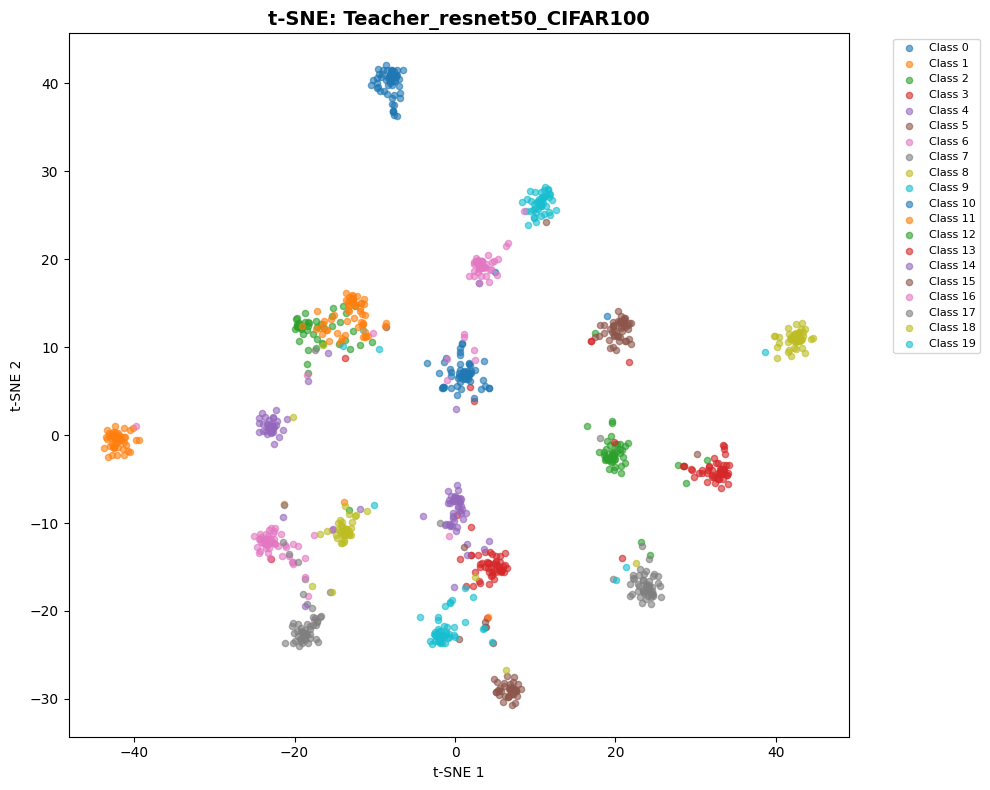

✓ Teacher visualization complete



In [8]:
FORCE_RETRAIN_TEACHER = False
teacher_model_path = f"pth_models/teacher_{TEACHER_ARCH}_cifar100.pth"

if os.path.exists(teacher_model_path) and not FORCE_RETRAIN_TEACHER:
    print(f"Loading teacher from {teacher_model_path}")
    teacher = timm.create_model(
        "resnet50_cifar100", pretrained=False, num_classes=num_classes
    ).to(device)

    checkpoint = torch.load(teacher_model_path, map_location=device)
    new_state_dict = {}
    for k, v in checkpoint.items():
        if k.startswith("final_classifier") or k.startswith("classifier"):
            new_key = k.replace("final_classifier", "fc").replace("classifier", "fc")
        else:
            new_key = k
        new_state_dict[new_key] = v

    msg = teacher.load_state_dict(new_state_dict, strict=False)

    if len(msg.unexpected_keys) > 0:
        print("Cleaning checkpoint (removing auxiliary weights)...")
        torch.save(teacher.state_dict(), teacher_model_path)
else:
    teacher = timm.create_model(
        "resnet50_cifar100", pretrained=False, num_classes=num_classes
    ).to(device)
    optimizer_teacher = torch.optim.Adam(teacher.parameters(), lr=LR)
    criterion_teacher = nn.CrossEntropyLoss()

    scheduler_teacher = None
    if USE_LR_SCHEDULER:
        scheduler_teacher = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer_teacher, T_max=EPOCHS_TEACHER
        )

    teacher, teacher_log = train_teacher(
        teacher,
        train_loader,
        optimizer_teacher,
        criterion_teacher,
        device,
        epochs=EPOCHS_TEACHER,
        scheduler=scheduler_teacher,
        log_name=f"teacher_{TEACHER_ARCH}_cifar100",
    )
    torch.save(teacher.state_dict(), teacher_model_path)

acc_teacher = evaluate_model(teacher, test_loader, device)
print(f"\n{'='*50}")
print(f"Teacher Test Accuracy: {acc_teacher}%")
print(f"{'='*50}\n")

# No projection head training - use raw features
print("\n✓ Using raw 2048-dim features (no projection)")

# Visualize teacher's latent space
print("📊 Visualizing teacher's latent space...")
original_fc = teacher.fc
teacher.fc = nn.Identity()
try:
    visualize_latents(
        teacher,
        test_loader,
        device,
        title=f"Teacher_{TEACHER_ARCH}_CIFAR100",
        sample_classes=sample_classes,
    )
    print("✓ Teacher visualization complete\n")
finally:
    teacher.fc = original_fc

Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 100.96it/s]


Projections shape: (10000, 2048)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running t-SNE (this may take a minute)...
✓ Saved to plots/hypersphere_trained_projection.png


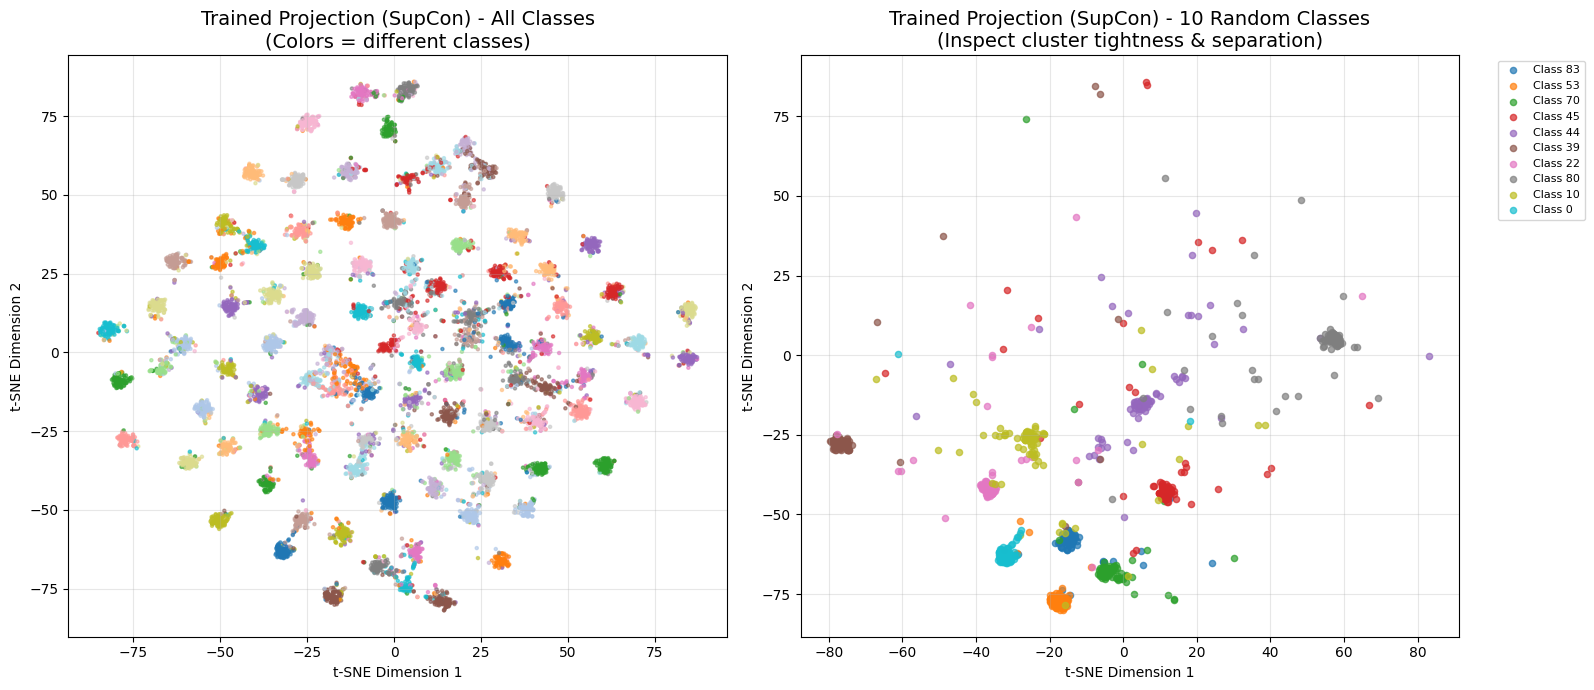


HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.2324
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.6076
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 2.6150
  → Higher = better overall (clear clusters)


In [9]:
# Visualize the trained projection's hypersphere distribution
metrics = visualize_hypersphere_distribution(
    teacher, 
    test_loader, 
    device,
    title="Trained Projection (SupCon)",
    save_path="plots/hypersphere_trained_projection.png"
)

Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 102.78it/s]


Projections shape: (10000, 2048)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:00<00:00, 142.48it/s]


Computing uniformity (angular distribution)...


/tmp/ipykernel_30646/2628682699.py:290: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Saved to plots/teacher_alignment_uniformity.png


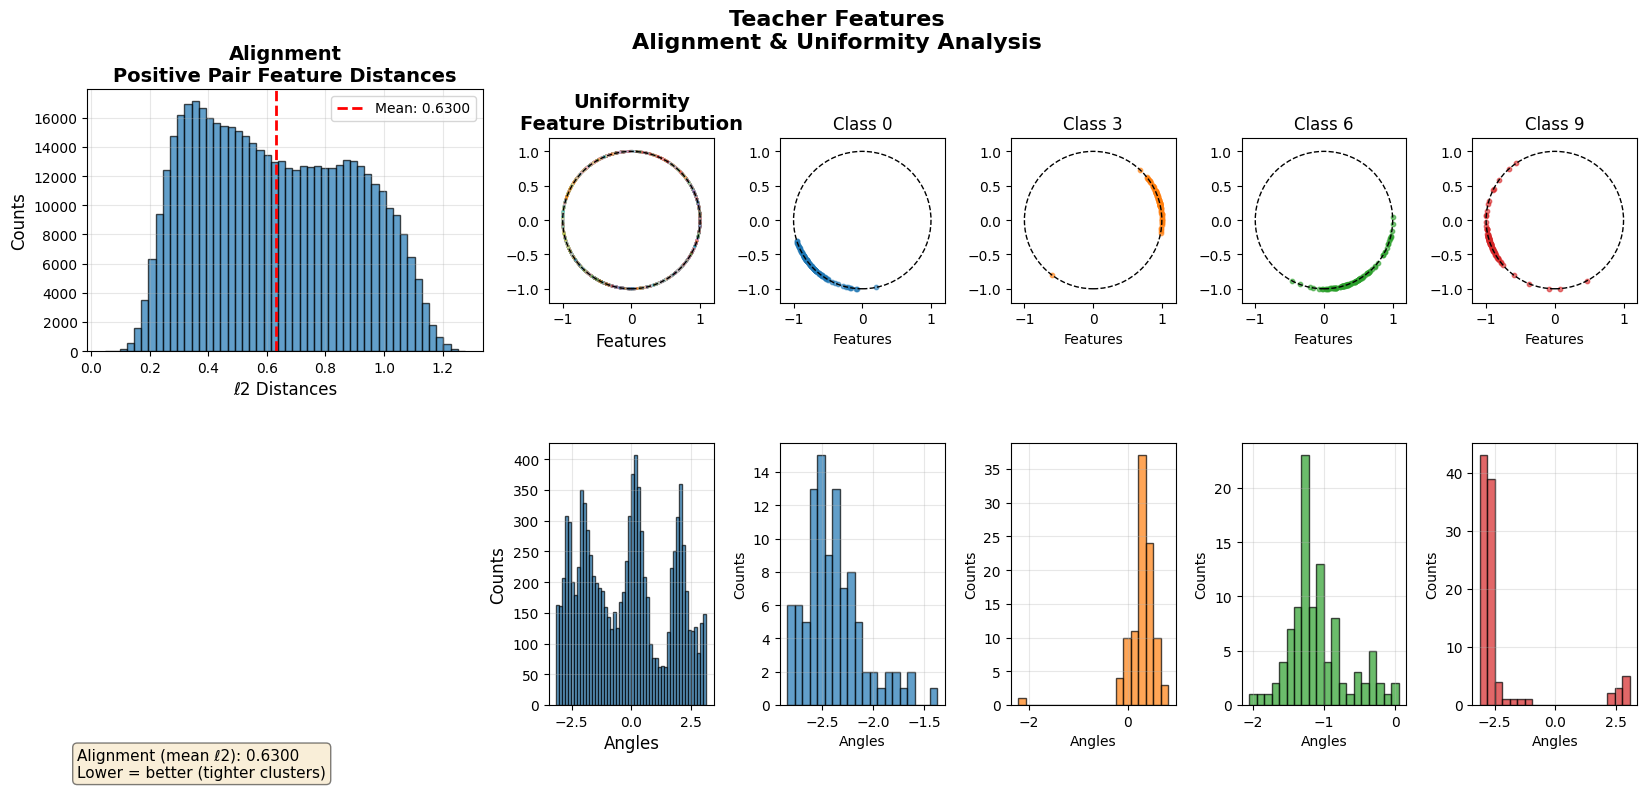


ALIGNMENT & UNIFORMITY METRICS
Alignment (positive pair ℓ2 distance):
  Mean: 0.6300
  Std:  0.2605
  → Lower = better (tighter clusters)

Uniformity (angular coverage):
  Angle std: 1.7676
  → Higher = better (more uniform distribution)

Extracting projections for Wang & Isola metrics (teacher)...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 101.89it/s]


Wang & Isola Metrics:
  Alignment loss (t=2): 0.4647 (lower = better)
  Uniformity loss (t=2): -2.6309 (lower = better)

TEACHER QUALITY SUMMARY
Test Accuracy: 80.75%

Hypersphere metrics:
  Intra-class distance: 0.2324
  Inter-class distance: 0.6076
  Separation ratio: 2.6150

Alignment & Uniformity:
  Alignment loss: 0.4647
  Uniformity loss: -2.6309


In [10]:
# This is all you need:
metrics_alignment = visualize_alignment_uniformity(
    teacher,
    test_loader,
    device,
    title="Teacher Features",
    save_path="plots/teacher_alignment_uniformity.png",
)

# Extract projections for Wang & Isola metrics (teacher)
print("\nExtracting projections for Wang & Isola metrics (teacher)...")
all_projections_teacher = []
all_labels_teacher = []

teacher.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Extracting"):
        images = images.to(device)

        # Get raw features (2048-dim)
        original_fc = teacher.fc
        teacher.fc = nn.Identity()
        features = teacher(images)
        teacher.fc = original_fc

        # Normalize raw features
        proj = F.normalize(features, dim=1)

        all_projections_teacher.append(proj.cpu())
        all_labels_teacher.append(labels)

projections_teacher = torch.cat(all_projections_teacher, dim=0)
labels_teacher = torch.cat(all_labels_teacher, dim=0)

# Wang & Isola losses
align_loss_teacher, uniform_loss_teacher = compute_alignment_uniformity_loss(
    projections_teacher, labels_teacher, t_align=2, t_uniform=2
)

print("\n" + "=" * 60)
print("TEACHER QUALITY SUMMARY")
print("=" * 60)
print(f"Test Accuracy: {acc_teacher:.2f}%")
print(f"\nHypersphere metrics:")
print(f"  Intra-class distance: {metrics['intra_class_dist']:.4f}")
print(f"  Inter-class distance: {metrics['inter_class_dist']:.4f}")
print(f"  Separation ratio: {metrics['separation_ratio']:.4f}")
print(f"\nAlignment & Uniformity:")
print(f"  Alignment loss: {align_loss_teacher:.4f}")
print(f"  Uniformity loss: {uniform_loss_teacher:.4f}")
print("=" * 60)

---
## EXPERIMENT 2: Baseline SupCon

Loading baseline from pth_models/student_baseline_supcon_resnet18_cifar100.pth
  Train Acc (final): 90.81%

Baseline SupCon Test Accuracy: 69.08%

📊 Visualizing baseline's latent space...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


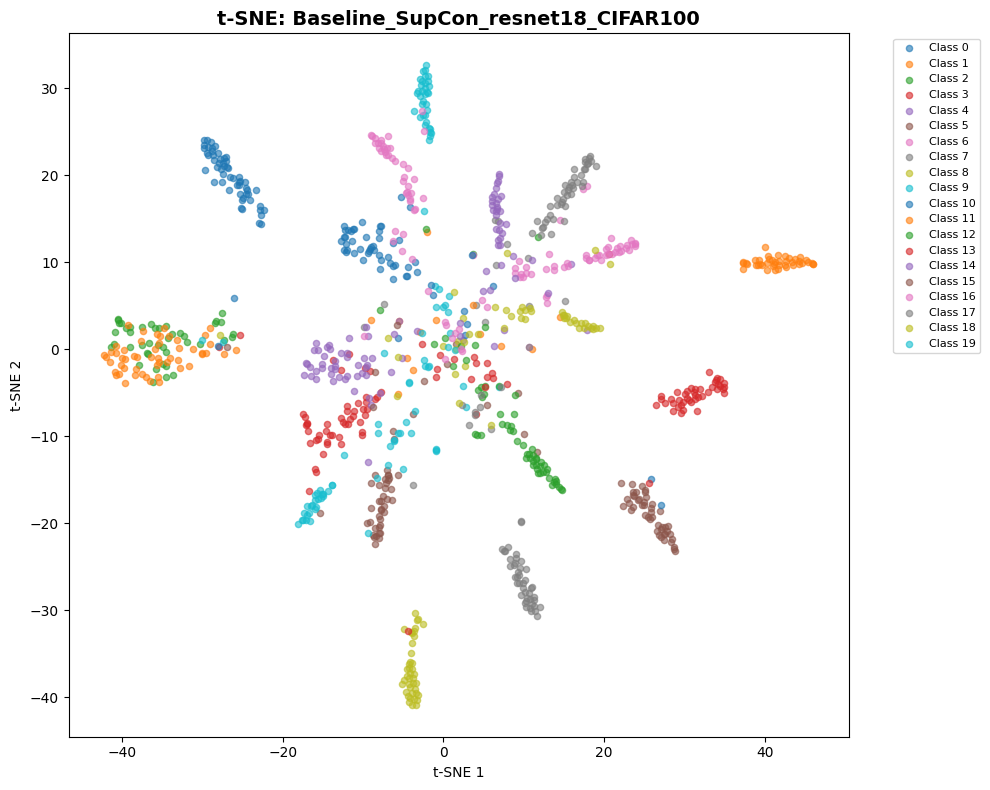

✓ Baseline visualization complete



In [11]:
FORCE_RETRAIN_BASELINE = False
baseline_model_path = f'pth_models/student_baseline_supcon_{STUDENT_ARCH}_cifar100.pth'

baseline_log = load_training_log(f'baseline_supcon_{STUDENT_ARCH}_cifar100')
if os.path.exists(baseline_model_path) and not FORCE_RETRAIN_BASELINE and baseline_log:
    print(f"Loading baseline from {baseline_model_path}")
    student_baseline = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(device)
    student_baseline.load_state_dict(torch.load(baseline_model_path, map_location=device))
    print(f"  Train Acc (final): {baseline_log['train_acc'][-1]:.2f}%")
else:
    student_baseline = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(device)
    optimizer_baseline = torch.optim.Adam(student_baseline.parameters(), lr=LR)
    criterion_baseline = SupConLoss(temperature=TEMP)
    student_baseline, baseline_log = train_student(
        teacher, student_baseline, train_loader, optimizer_baseline,
        criterion_baseline, device, epochs=EPOCHS_STUDENT,
        label="Baseline_SupCon", mode='supcon', 
        log_name=f'baseline_supcon_{STUDENT_ARCH}_cifar100'
    )
    torch.save(student_baseline.state_dict(), baseline_model_path)

acc_baseline = evaluate_model(student_baseline, test_loader, device)
print(f"\n{'='*50}")
print(f"Baseline SupCon Test Accuracy: {acc_baseline}%")
print(f"{'='*50}\n")

# Visualize baseline's latent space
print("📊 Visualizing baseline's latent space...")
visualize_latents(
    student_baseline, 
    test_loader, 
    device, 
    title=f"Baseline_SupCon_{STUDENT_ARCH}_CIFAR100",
    sample_classes=sample_classes
)
print("✓ Baseline visualization complete\n")


📊 Hypersphere Distribution...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 277.39it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running t-SNE (this may take a minute)...
✓ Saved to plots/baseline_student_hypersphere.png


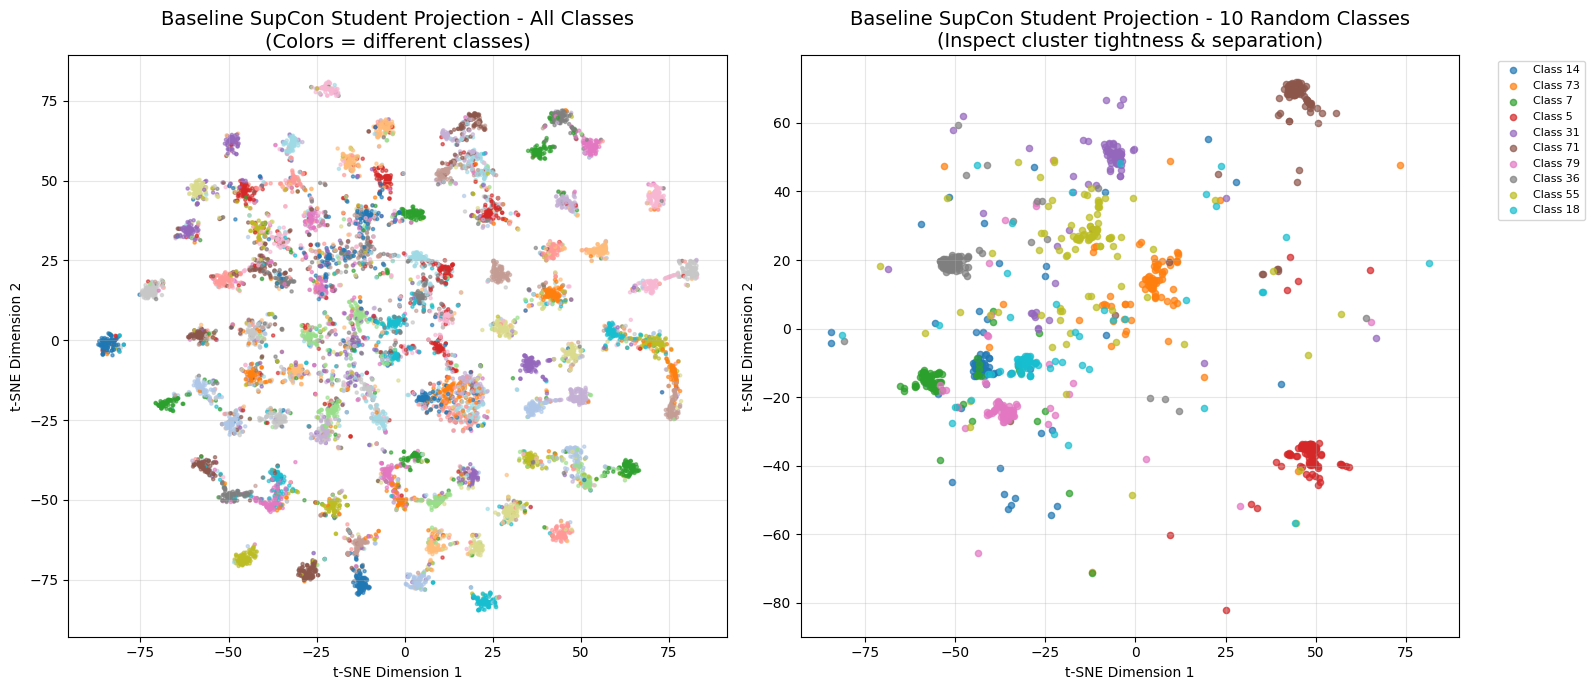


HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.2189
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.6338
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 2.8959
  → Higher = better overall (clear clusters)

📊 Alignment & Uniformity Analysis...
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 280.89it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:00<00:00, 158.44it/s]
/tmp/ipykernel_30646/2628682699.py:290: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Computing uniformity (angular distribution)...
✓ Saved to plots/baseline_student_alignment_uniformity.png


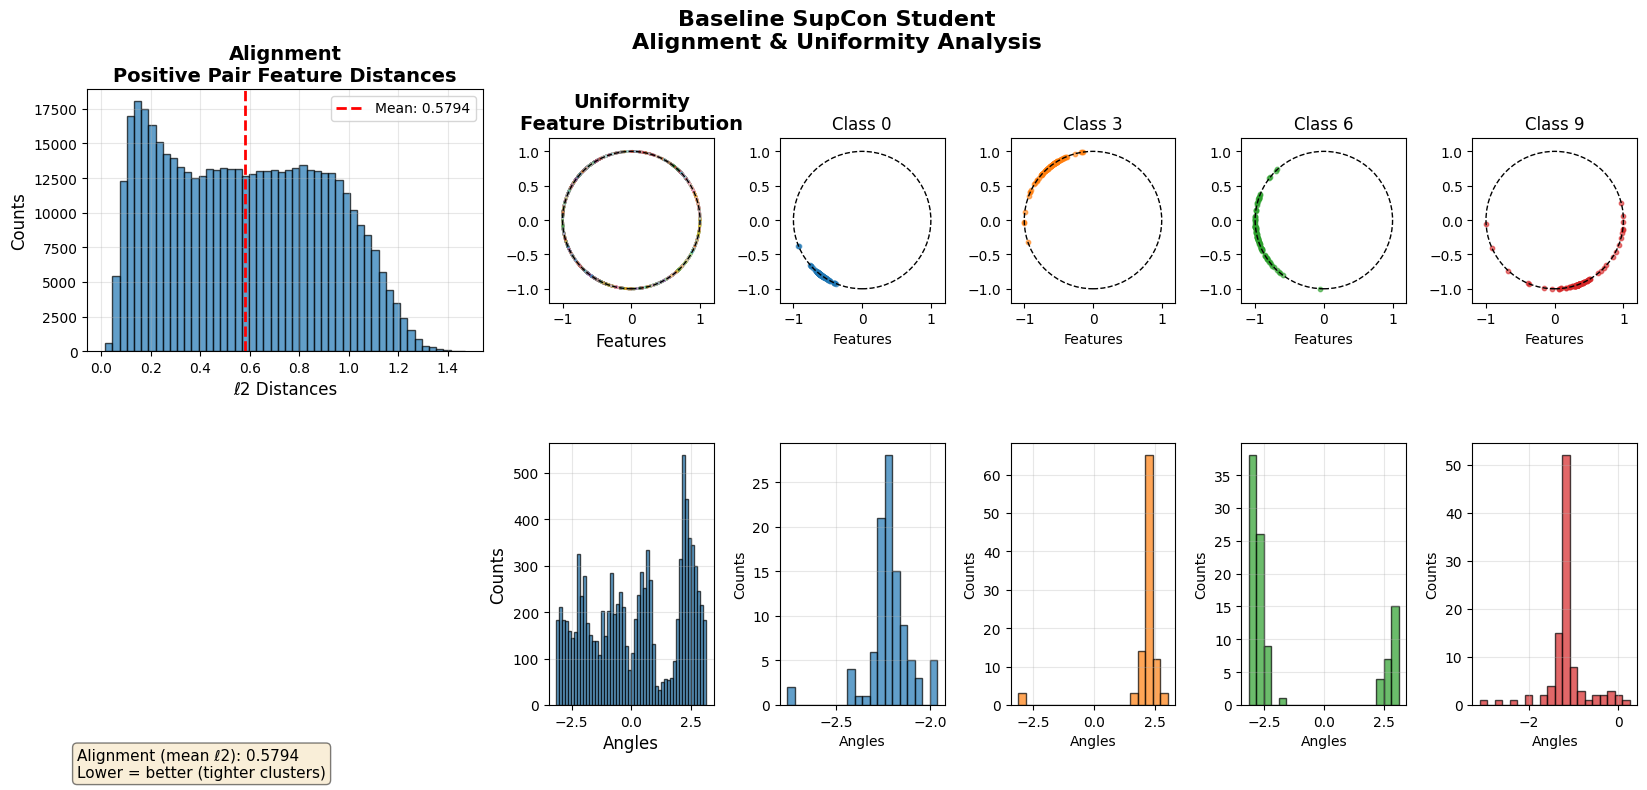


ALIGNMENT & UNIFORMITY METRICS
Alignment (positive pair ℓ2 distance):
  Mean: 0.5794
  Std:  0.3195
  → Lower = better (tighter clusters)

Uniformity (angular coverage):
  Angle std: 1.9016
  → Higher = better (more uniform distribution)

Extracting projections for Wang & Isola metrics...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 279.22it/s]


Wang & Isola Metrics:
  Alignment loss (t=2): 0.4377 (lower = better)
  Uniformity loss (t=2): -2.5498 (lower = better)

BASELINE STUDENT QUALITY SUMMARY
Test Accuracy: 69.08%

Hypersphere metrics:
  Intra-class distance: 0.2189
  Inter-class distance: 0.6338
  Separation ratio: 2.8959

Alignment & Uniformity:
  Alignment loss: 0.4377
  Uniformity loss: -2.5498


In [12]:
# Hypersphere distribution
print("\n📊 Hypersphere Distribution...")
metrics_baseline_hyper = visualize_hypersphere_distribution(
    student_baseline,
    test_loader,
    device,
    title="Baseline SupCon Student Projection",
    save_path="plots/baseline_student_hypersphere.png"
)

# Alignment & Uniformity
print("\n📊 Alignment & Uniformity Analysis...")
metrics_baseline_align = visualize_alignment_uniformity(
    student_baseline,
    test_loader,
    device,
    title="Baseline SupCon Student",
    save_path="plots/baseline_student_alignment_uniformity.png"
)

# Extract projections for Wang & Isola metrics
print("\nExtracting projections for Wang & Isola metrics...")
all_projections_baseline = []
all_labels_baseline = []

student_baseline.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Extracting"):
        images = images.to(device)
        
        # Get student projections (ModelWrapper has encoder + projector)
        features = student_baseline.encoder(images)
        proj = student_baseline.projector(features)
        proj = F.normalize(proj, dim=1)
        
        all_projections_baseline.append(proj.cpu())
        all_labels_baseline.append(labels)

projections_baseline = torch.cat(all_projections_baseline, dim=0)
labels_baseline = torch.cat(all_labels_baseline, dim=0)

# Wang & Isola losses
align_loss_baseline, uniform_loss_baseline = compute_alignment_uniformity_loss(
    projections_baseline, labels_baseline, t_align=2, t_uniform=2
)

print("\n" + "="*60)
print("BASELINE STUDENT QUALITY SUMMARY")
print("="*60)
print(f"Test Accuracy: {acc_baseline:.2f}%")
print(f"\nHypersphere metrics:")
print(f"  Intra-class distance: {metrics_baseline_hyper['intra_class_dist']:.4f}")
print(f"  Inter-class distance: {metrics_baseline_hyper['inter_class_dist']:.4f}")
print(f"  Separation ratio: {metrics_baseline_hyper['separation_ratio']:.4f}")
print(f"\nAlignment & Uniformity:")
print(f"  Alignment loss: {align_loss_baseline:.4f}")
print(f"  Uniformity loss: {uniform_loss_baseline:.4f}")
print("="*60)

---
## EXPERIMENT 3: Alpha Sweep (β=1 fixed)

Loading alpha_1.0_beta_1.0 from cache
α=1.0: Train=98.622%, Test=72.3%

📊 Visualizing α=1.0...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


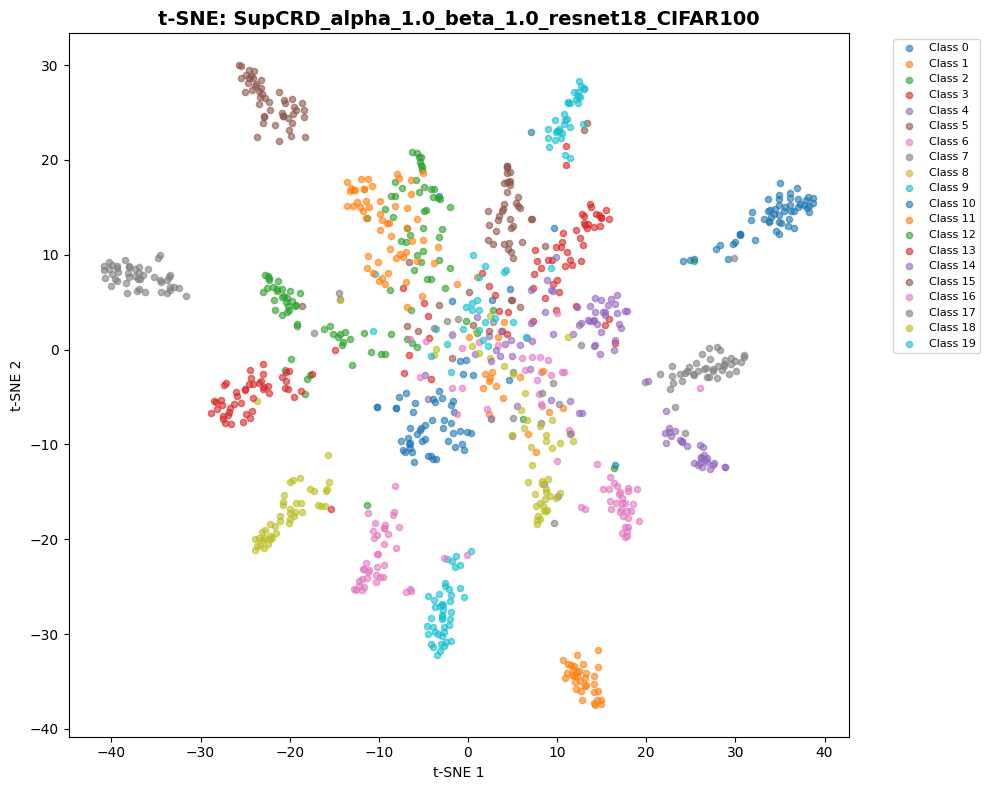

✓ α=1.0 visualization complete


📊 Quality Analysis for α=1.0...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 282.07it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running t-SNE (this may take a minute)...
✓ Saved to plots/alpha_1.0_hypersphere.png


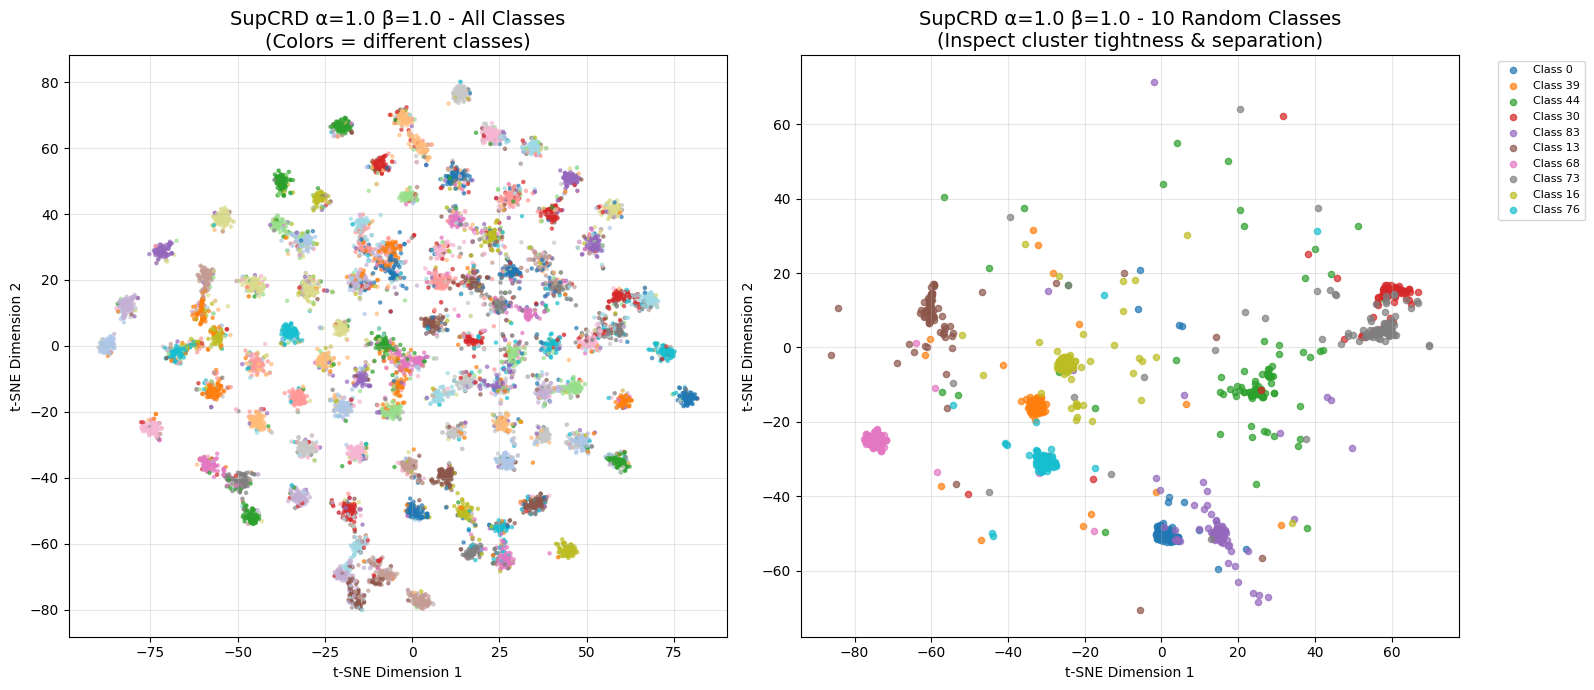


HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.4543
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9811
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 2.1597
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 290.27it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:00<00:00, 164.50it/s]
/tmp/ipykernel_30646/2628682699.py:290: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Computing uniformity (angular distribution)...
✓ Saved to plots/alpha_1.0_alignment.png


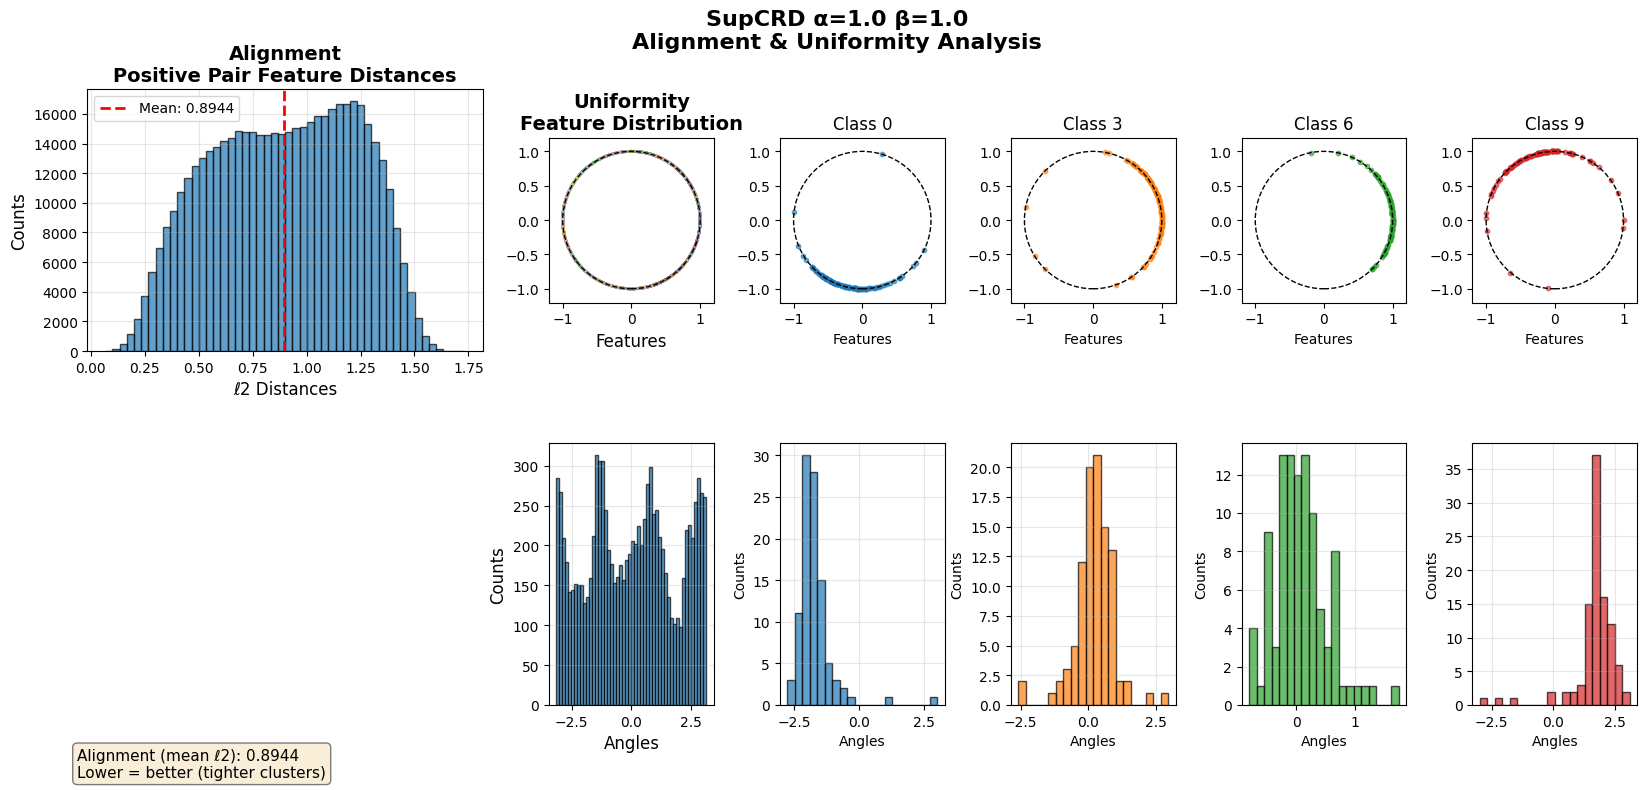


ALIGNMENT & UNIFORMITY METRICS
Alignment (positive pair ℓ2 distance):
  Mean: 0.8944
  Std:  0.3296
  → Lower = better (tighter clusters)

Uniformity (angular coverage):
  Angle std: 1.8354
  → Higher = better (more uniform distribution)


Extracting: 100%|██████████| 79/79 [00:00<00:00, 285.60it/s]



Wang & Isola Metrics:
  Alignment loss (t=2): 0.9086 (lower = better)
  Uniformity loss (t=2): -3.6048 (lower = better)
  Intra-class: 0.4543 | Inter-class: 0.9811
  Alignment: 0.9086 | Uniformity: -3.6048

Loading alpha_2.0_beta_1.0 from cache
α=2.0: Train=97.868%, Test=70.98%

📊 Visualizing α=2.0...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


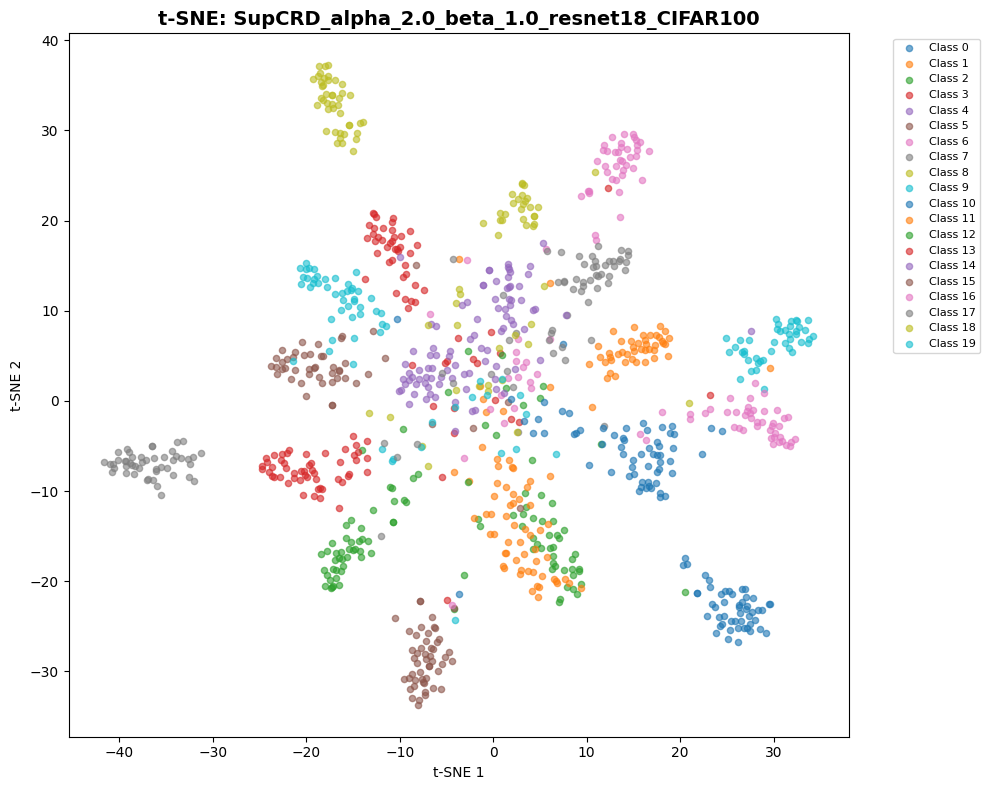

✓ α=2.0 visualization complete


📊 Quality Analysis for α=2.0...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 274.29it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running t-SNE (this may take a minute)...
✓ Saved to plots/alpha_2.0_hypersphere.png


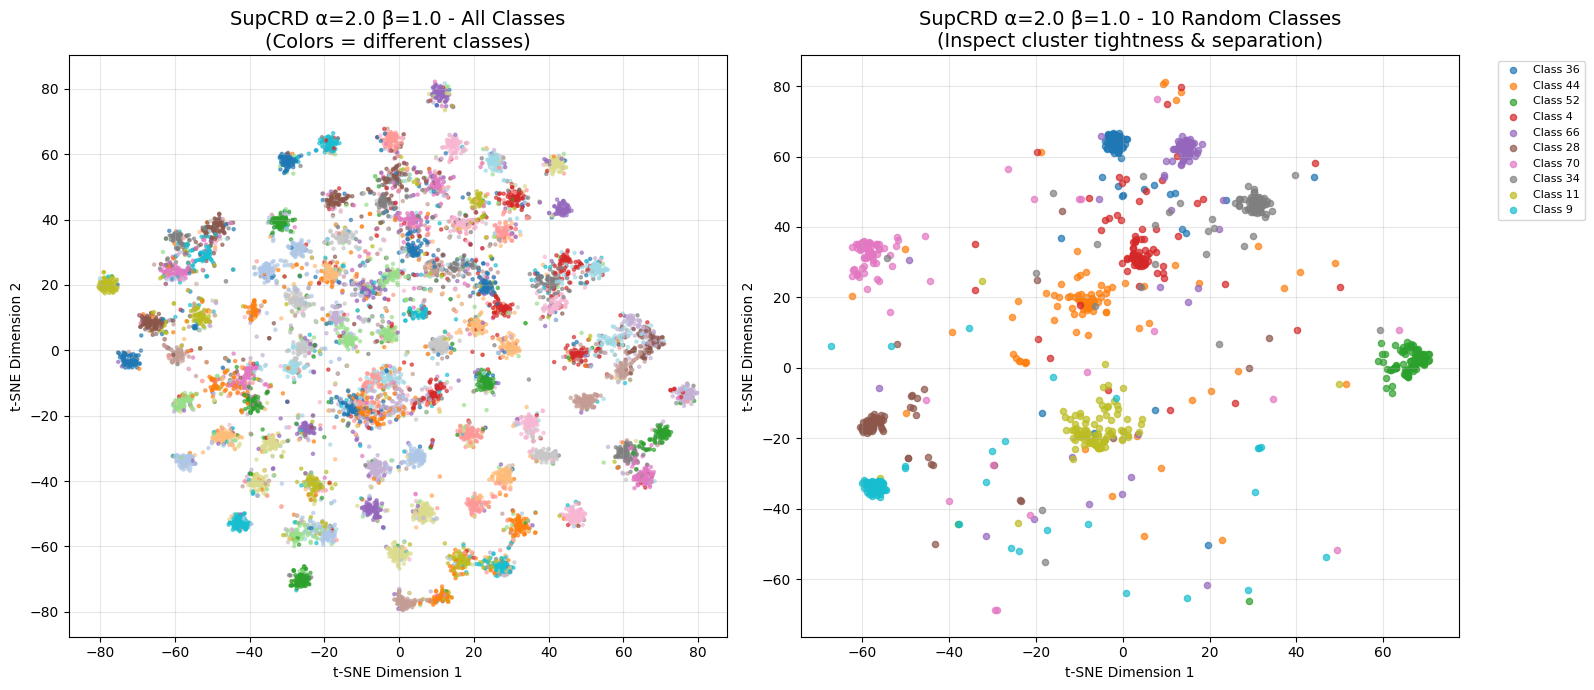


HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.4844
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9506
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 1.9625
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 282.54it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:00<00:00, 157.10it/s]
/tmp/ipykernel_30646/2628682699.py:290: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Computing uniformity (angular distribution)...
✓ Saved to plots/alpha_2.0_alignment.png


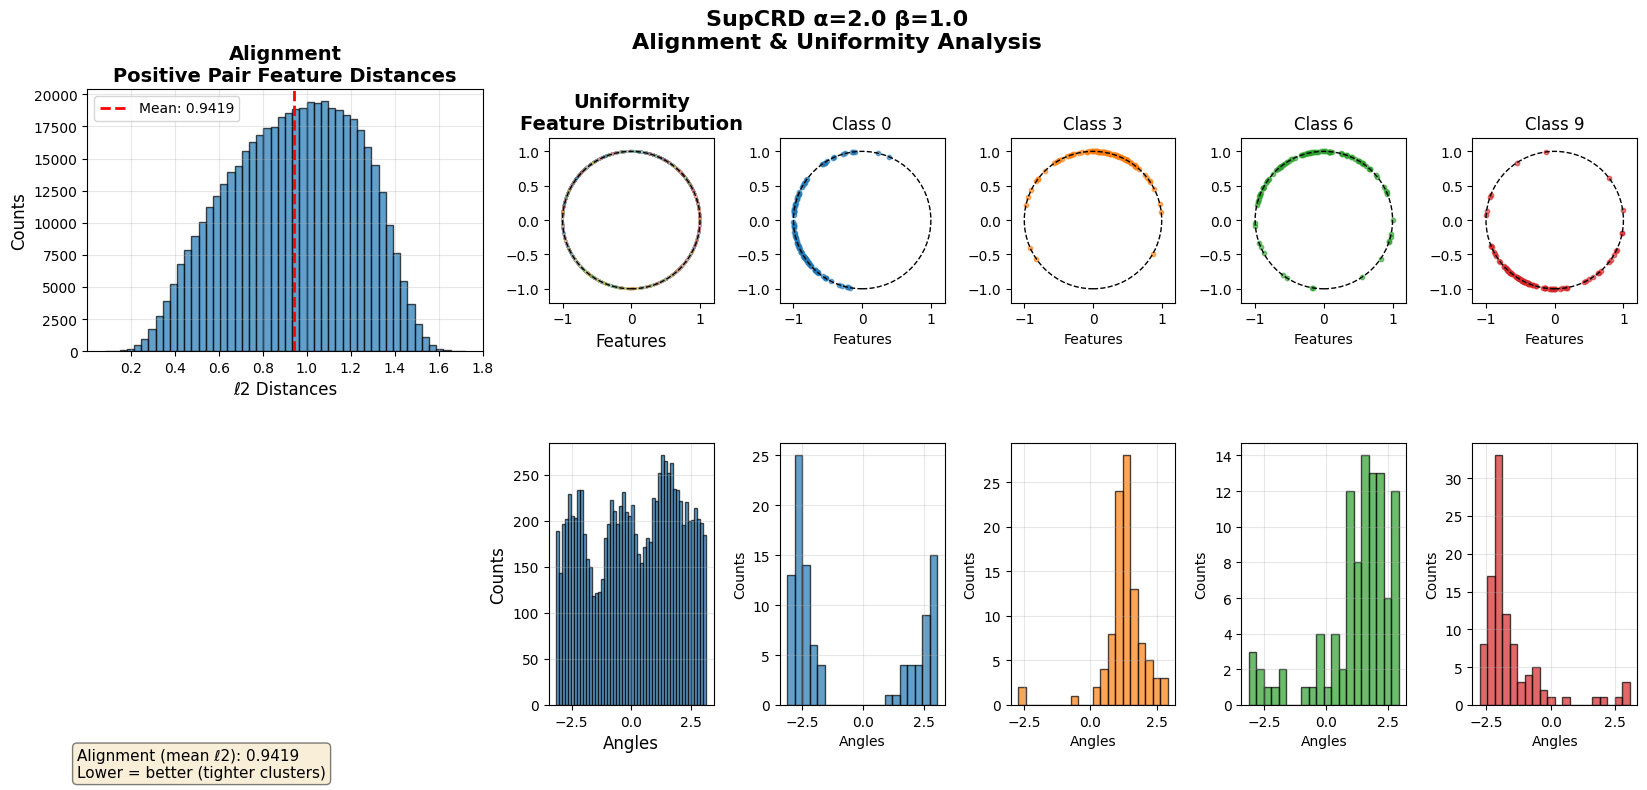


ALIGNMENT & UNIFORMITY METRICS
Alignment (positive pair ℓ2 distance):
  Mean: 0.9419
  Std:  0.2857
  → Lower = better (tighter clusters)

Uniformity (angular coverage):
  Angle std: 1.8106
  → Higher = better (more uniform distribution)


Extracting: 100%|██████████| 79/79 [00:00<00:00, 282.50it/s]


Wang & Isola Metrics:
  Alignment loss (t=2): 0.9687 (lower = better)
  Uniformity loss (t=2): -3.6171 (lower = better)
  Intra-class: 0.4844 | Inter-class: 0.9506
  Alignment: 0.9687 | Uniformity: -3.6171


ALPHA SWEEP SUMMARY (β=1.0, τ=0.07)
α=  1.0: Test=72.30% (Δ=+3.22%)
α=  2.0: Test=70.98% (Δ=+1.90%)



In [13]:
FORCE_RETRAIN_ALPHA_SWEEP = False

alpha_results = {}
for alpha_val in ALPHA_SWEEP:
    exp_name = f'alpha_{alpha_val}_beta_1.0'
    model_path = f'pth_models/student_{exp_name}_{STUDENT_ARCH}_cifar100.pth'
    
    log = load_training_log(f'{exp_name}_{STUDENT_ARCH}_cifar100')
    if os.path.exists(model_path) and not FORCE_RETRAIN_ALPHA_SWEEP and log:
        print(f"Loading {exp_name} from cache")
        student = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(device)
        student.load_state_dict(torch.load(model_path, map_location=device))
        train_acc = log['train_acc'][-1]
    else:
        student = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=LR)
        criterion = LogitWeightedSupCRDLoss(alpha=alpha_val, beta=1.0, temperature=TEMP)
        student, log = train_student(
            teacher, student, train_loader, optimizer, criterion, device,
            epochs=EPOCHS_STUDENT, label=f'SupCRD_α={alpha_val}', mode='supcrd',
            log_name=f'{exp_name}_{STUDENT_ARCH}_cifar100'
        )
        torch.save(student.state_dict(), model_path)
        train_acc = log['train_acc'][-1]
    
    test_acc = evaluate_model(student, test_loader, device)
    alpha_results[alpha_val] = {'train': train_acc, 'test': test_acc}
    print(f"α={alpha_val}: Train={train_acc}%, Test={test_acc}%\n")
    
    # Visualize this alpha config
    print(f"📊 Visualizing α={alpha_val}...")
    visualize_latents(student, test_loader, device,
        title=f"SupCRD_alpha_{alpha_val}_beta_1.0_{STUDENT_ARCH}_CIFAR100",
        sample_classes=sample_classes)
    print(f"✓ α={alpha_val} visualization complete\n")
    
    # Quality analysis
    print(f"\n📊 Quality Analysis for α={alpha_val}...")
    metrics_hyper = visualize_hypersphere_distribution(
        student, test_loader, device,
        title=f"SupCRD α={alpha_val} β=1.0",
        save_path=f"plots/alpha_{alpha_val}_hypersphere.png"
    )
    metrics_align = visualize_alignment_uniformity(
        student, test_loader, device,
        title=f"SupCRD α={alpha_val} β=1.0",
        save_path=f"plots/alpha_{alpha_val}_alignment.png"
    )
    # Wang & Isola metrics
    all_proj, all_lab = [], []
    student.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Extracting"):
            images = images.to(device)
            features = student.encoder(images)
            proj = F.normalize(student.projector(features), dim=1)
            all_proj.append(proj.cpu())
            all_lab.append(labels)
    proj_tensor = torch.cat(all_proj, dim=0)
    lab_tensor = torch.cat(all_lab, dim=0)
    align_loss, uniform_loss = compute_alignment_uniformity_loss(proj_tensor, lab_tensor, t_align=2, t_uniform=2)
    print(f"  Intra-class: {metrics_hyper['intra_class_dist']:.4f} | Inter-class: {metrics_hyper['inter_class_dist']:.4f}")
    print(f"  Alignment: {align_loss:.4f} | Uniformity: {uniform_loss:.4f}\n")

# Summary
print(f"\n{'='*60}")
print(f"ALPHA SWEEP SUMMARY (β=1.0, τ={TEMP})")
print(f"{'='*60}")
for alpha_val, res in alpha_results.items():
    delta = res['test'] - acc_baseline
    print(f"α={alpha_val:5.1f}: Test={res['test']:5.2f}% (Δ={delta:+.2f}%)")
print(f"{'='*60}\n")



---
## EXPERIMENT 4: Beta Sweep (α=1 fixed)

Loading alpha_1.0_beta_1.0 from cache
β=1.0: Train=98.622%, Test=72.3%

📊 Visualizing β=1.0...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


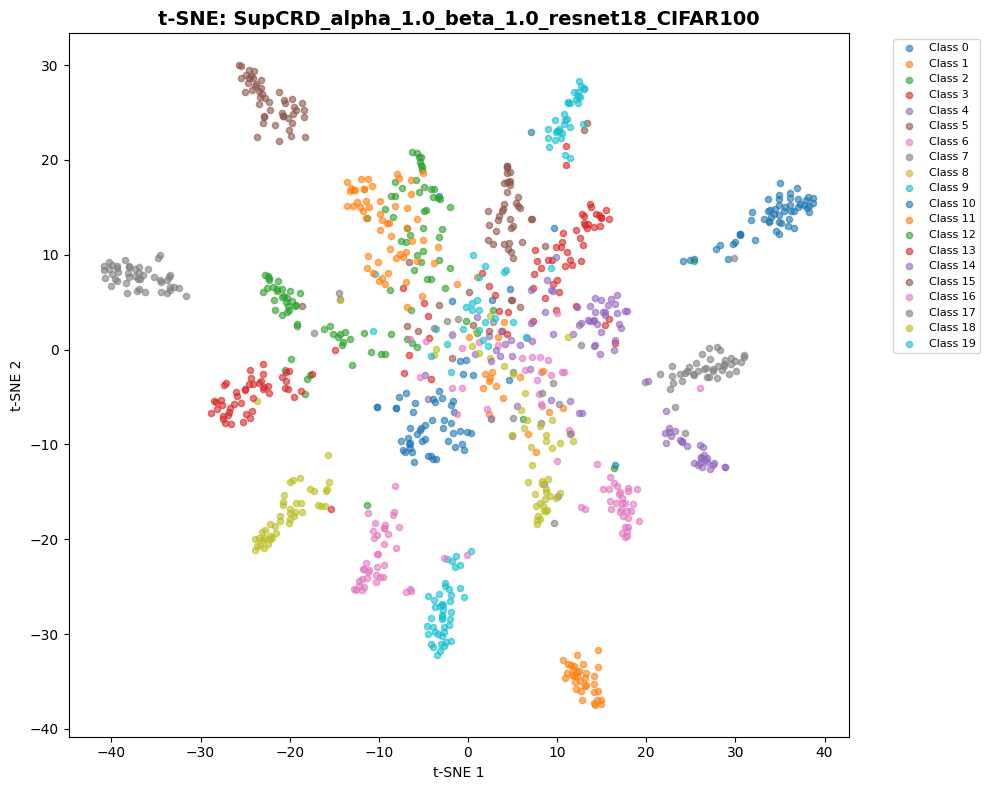

✓ β=1.0 visualization complete


📊 Quality Analysis for β=1.0...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 267.53it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running t-SNE (this may take a minute)...
✓ Saved to plots/beta_1.0_hypersphere.png


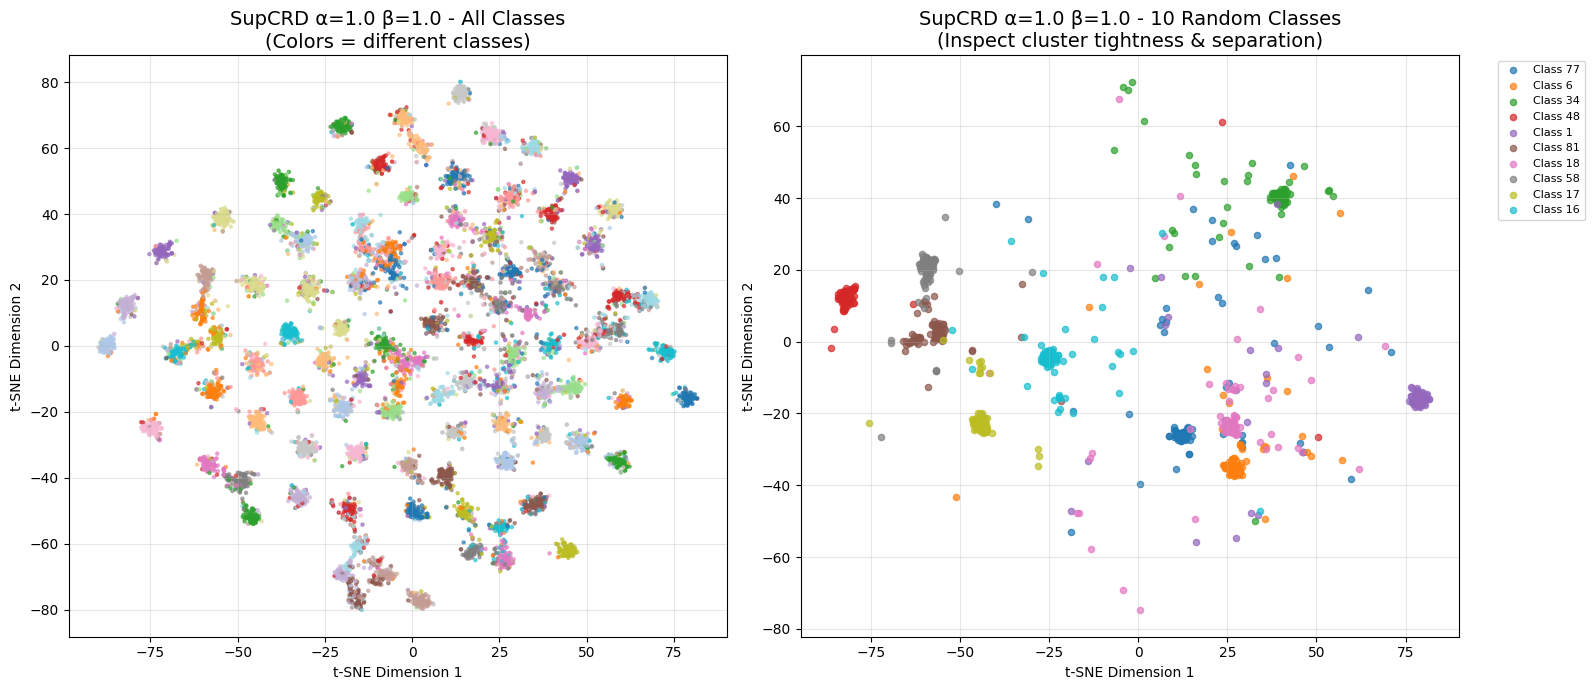


HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.4543
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9811
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 2.1597
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 267.32it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:00<00:00, 160.54it/s]
/tmp/ipykernel_30646/2628682699.py:290: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Computing uniformity (angular distribution)...
✓ Saved to plots/beta_1.0_alignment.png


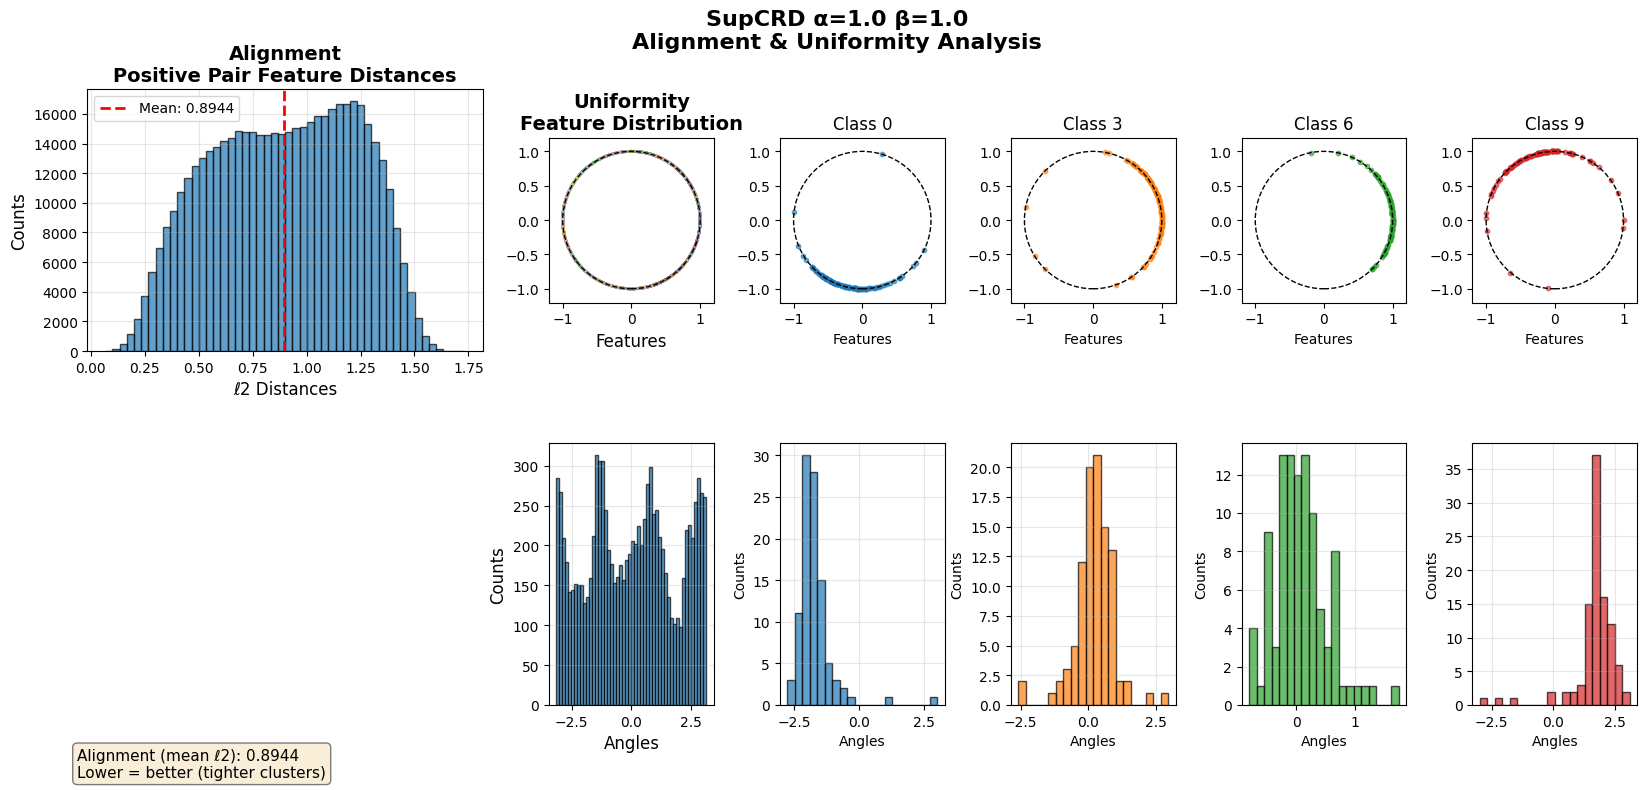


ALIGNMENT & UNIFORMITY METRICS
Alignment (positive pair ℓ2 distance):
  Mean: 0.8944
  Std:  0.3296
  → Lower = better (tighter clusters)

Uniformity (angular coverage):
  Angle std: 1.8354
  → Higher = better (more uniform distribution)


Extracting: 100%|██████████| 79/79 [00:00<00:00, 276.81it/s]



Wang & Isola Metrics:
  Alignment loss (t=2): 0.9086 (lower = better)
  Uniformity loss (t=2): -3.6501 (lower = better)
  Intra-class: 0.4543 | Inter-class: 0.9811
  Alignment: 0.9086 | Uniformity: -3.6501

Loading alpha_1.0_beta_10.0 from cache
β=10.0: Train=99.362%, Test=72.02%

📊 Visualizing β=10.0...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


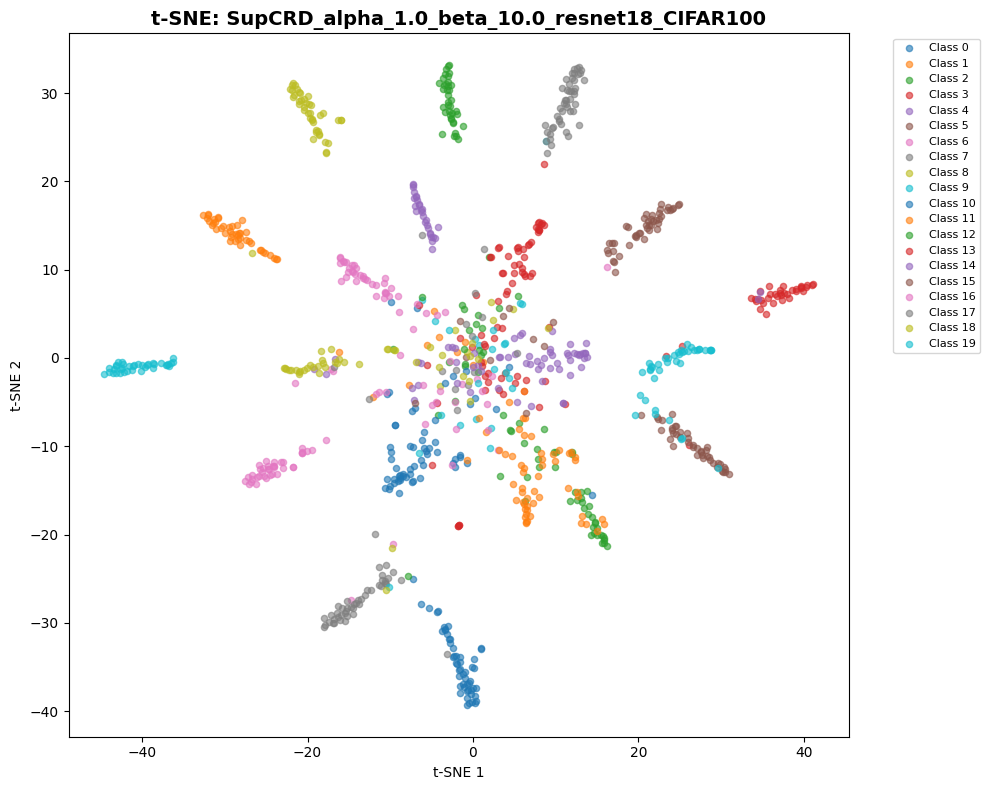

✓ β=10.0 visualization complete


📊 Quality Analysis for β=10.0...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 286.46it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running t-SNE (this may take a minute)...
✓ Saved to plots/beta_10.0_hypersphere.png


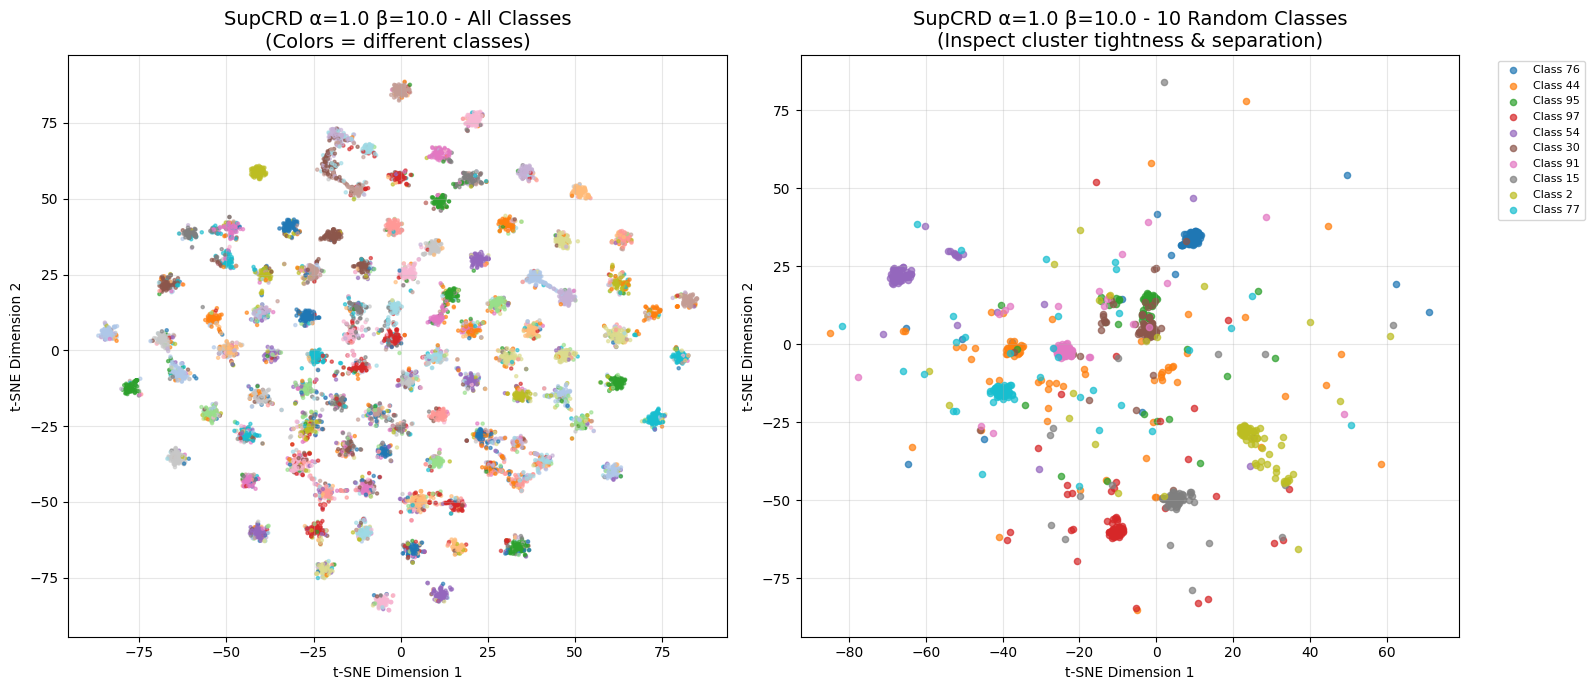


HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.4166
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9924
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 2.3820
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 273.96it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:00<00:00, 152.38it/s]
/tmp/ipykernel_30646/2628682699.py:290: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Computing uniformity (angular distribution)...
✓ Saved to plots/beta_10.0_alignment.png


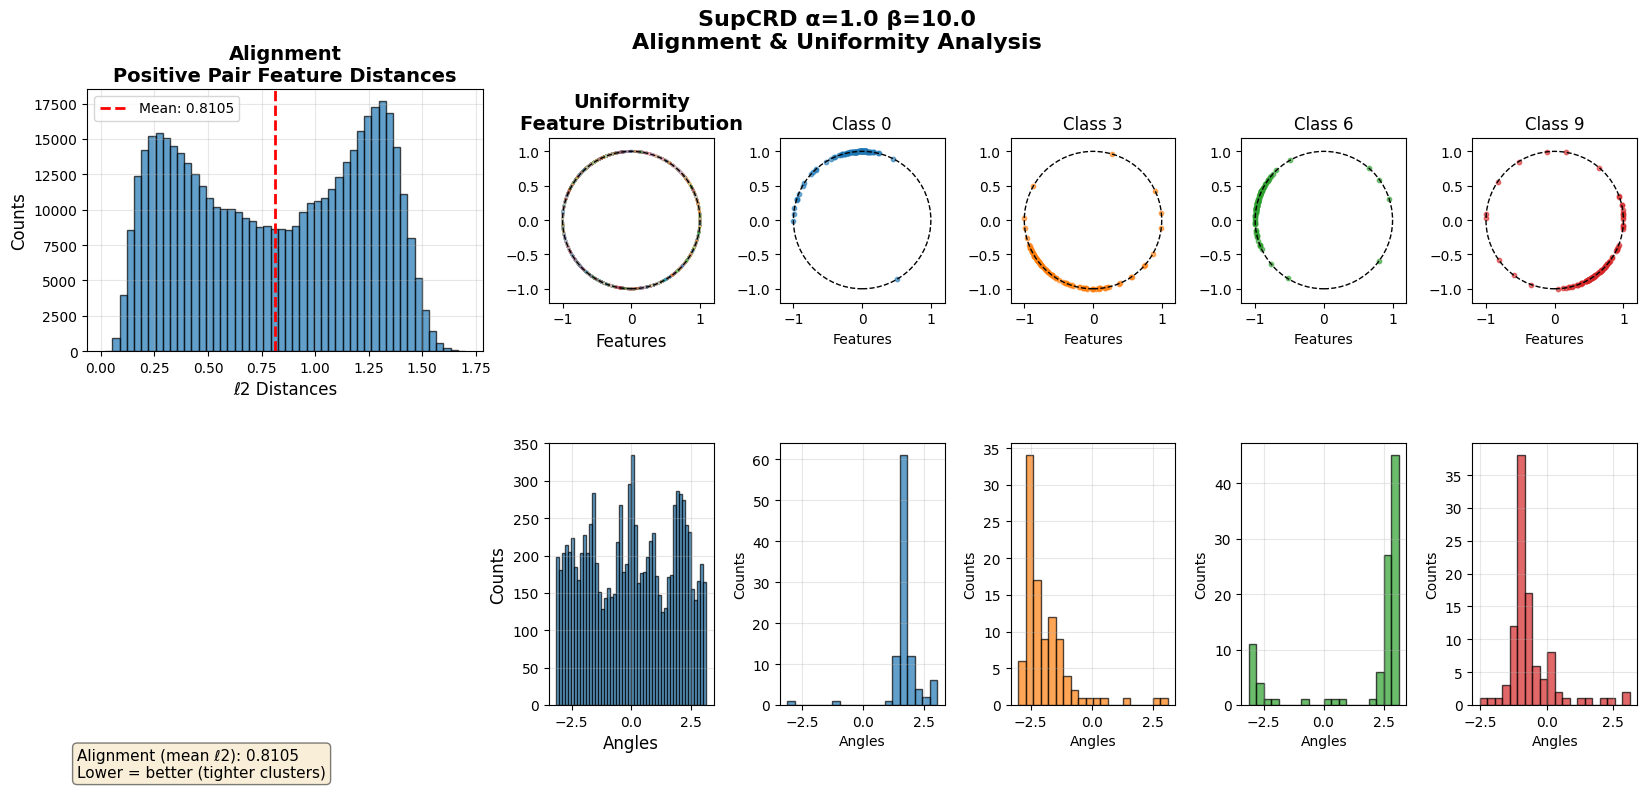


ALIGNMENT & UNIFORMITY METRICS
Alignment (positive pair ℓ2 distance):
  Mean: 0.8105
  Std:  0.4200
  → Lower = better (tighter clusters)

Uniformity (angular coverage):
  Angle std: 1.8048
  → Higher = better (more uniform distribution)


Extracting: 100%|██████████| 79/79 [00:00<00:00, 278.31it/s]


Wang & Isola Metrics:
  Alignment loss (t=2): 0.8333 (lower = better)
  Uniformity loss (t=2): -3.6027 (lower = better)
  Intra-class: 0.4166 | Inter-class: 0.9924
  Alignment: 0.8333 | Uniformity: -3.6027


BETA SWEEP SUMMARY (α=1.0, τ=0.07)
β=  1.0: Test=72.30% (Δ=+3.22%)
β= 10.0: Test=72.02% (Δ=+2.94%)



In [14]:
FORCE_RETRAIN_BETA_SWEEP = False

beta_results = {}
for beta_val in BETA_SWEEP:
    exp_name = f'alpha_1.0_beta_{beta_val}'
    model_path = f'pth_models/student_{exp_name}_{STUDENT_ARCH}_cifar100.pth'
    
    log = load_training_log(f'{exp_name}_{STUDENT_ARCH}_cifar100')
    if os.path.exists(model_path) and not FORCE_RETRAIN_BETA_SWEEP and log:
        print(f"Loading {exp_name} from cache")
        student = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(device)
        student.load_state_dict(torch.load(model_path, map_location=device))
        train_acc = log['train_acc'][-1]
    else:
        student = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=LR)
        criterion = LogitWeightedSupCRDLoss(alpha=1.0, beta=beta_val, temperature=TEMP)
        student, log = train_student(
            teacher, student, train_loader, optimizer, criterion, device,
            epochs=EPOCHS_STUDENT, label=f'SupCRD_β={beta_val}', mode='supcrd',
            log_name=f'{exp_name}_{STUDENT_ARCH}_cifar100'
        )
        torch.save(student.state_dict(), model_path)
        train_acc = log['train_acc'][-1]
    
    test_acc = evaluate_model(student, test_loader, device)
    beta_results[beta_val] = {'train': train_acc, 'test': test_acc}
    print(f"β={beta_val}: Train={train_acc}%, Test={test_acc}%\n")
    
    # Visualize this beta config
    print(f"📊 Visualizing β={beta_val}...")
    visualize_latents(student, test_loader, device,
        title=f"SupCRD_alpha_1.0_beta_{beta_val}_{STUDENT_ARCH}_CIFAR100",
        sample_classes=sample_classes)
    print(f"✓ β={beta_val} visualization complete\n")
    
    # Quality analysis
    print(f"\n📊 Quality Analysis for β={beta_val}...")
    metrics_hyper = visualize_hypersphere_distribution(
        student, test_loader, device,
        title=f"SupCRD α=1.0 β={beta_val}",
        save_path=f"plots/beta_{beta_val}_hypersphere.png"
    )
    metrics_align = visualize_alignment_uniformity(
        student, test_loader, device,
        title=f"SupCRD α=1.0 β={beta_val}",
        save_path=f"plots/beta_{beta_val}_alignment.png"
    )
    # Wang & Isola metrics
    all_proj, all_lab = [], []
    student.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Extracting"):
            images = images.to(device)
            features = student.encoder(images)
            proj = F.normalize(student.projector(features), dim=1)
            all_proj.append(proj.cpu())
            all_lab.append(labels)
    proj_tensor = torch.cat(all_proj, dim=0)
    lab_tensor = torch.cat(all_lab, dim=0)
    align_loss, uniform_loss = compute_alignment_uniformity_loss(proj_tensor, lab_tensor, t_align=2, t_uniform=2)
    print(f"  Intra-class: {metrics_hyper['intra_class_dist']:.4f} | Inter-class: {metrics_hyper['inter_class_dist']:.4f}")
    print(f"  Alignment: {align_loss:.4f} | Uniformity: {uniform_loss:.4f}\n")


# Summary
print(f"\n{'='*60}")
print(f"BETA SWEEP SUMMARY (α=1.0, τ={TEMP})")
print(f"{'='*60}")
for beta_val, res in beta_results.items():
    delta = res['test'] - acc_baseline
    print(f"β={beta_val:5.1f}: Test={res['test']:5.2f}% (Δ={delta:+.2f}%)")
print(f"{'='*60}\n")

---
## EXPERIMENT 5: Temperature Sweep (α=1, β=10)

Loading alpha_1.0_beta_10.0_temp_0.05 from cache
τ=0.05: Train=99.016%, Test=72.28%

📊 Visualizing τ=0.05...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


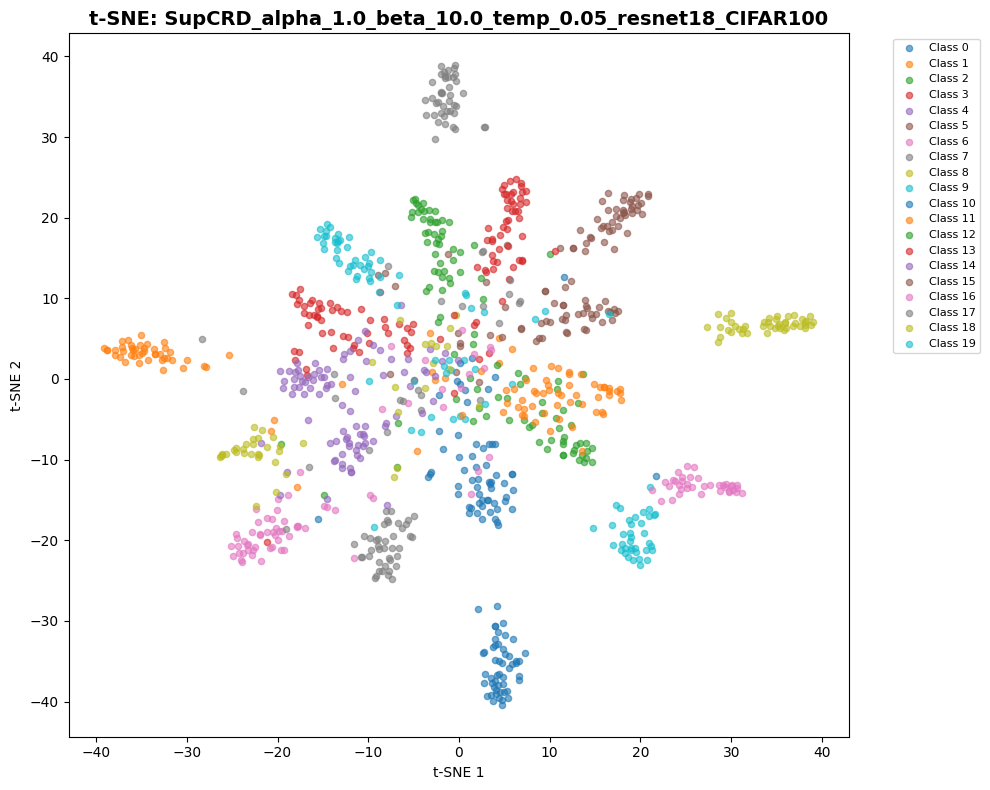

✓ τ=0.05 visualization complete


📊 Quality Analysis for τ=0.05...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 275.02it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running t-SNE (this may take a minute)...
✓ Saved to plots/temp_0.05_hypersphere.png


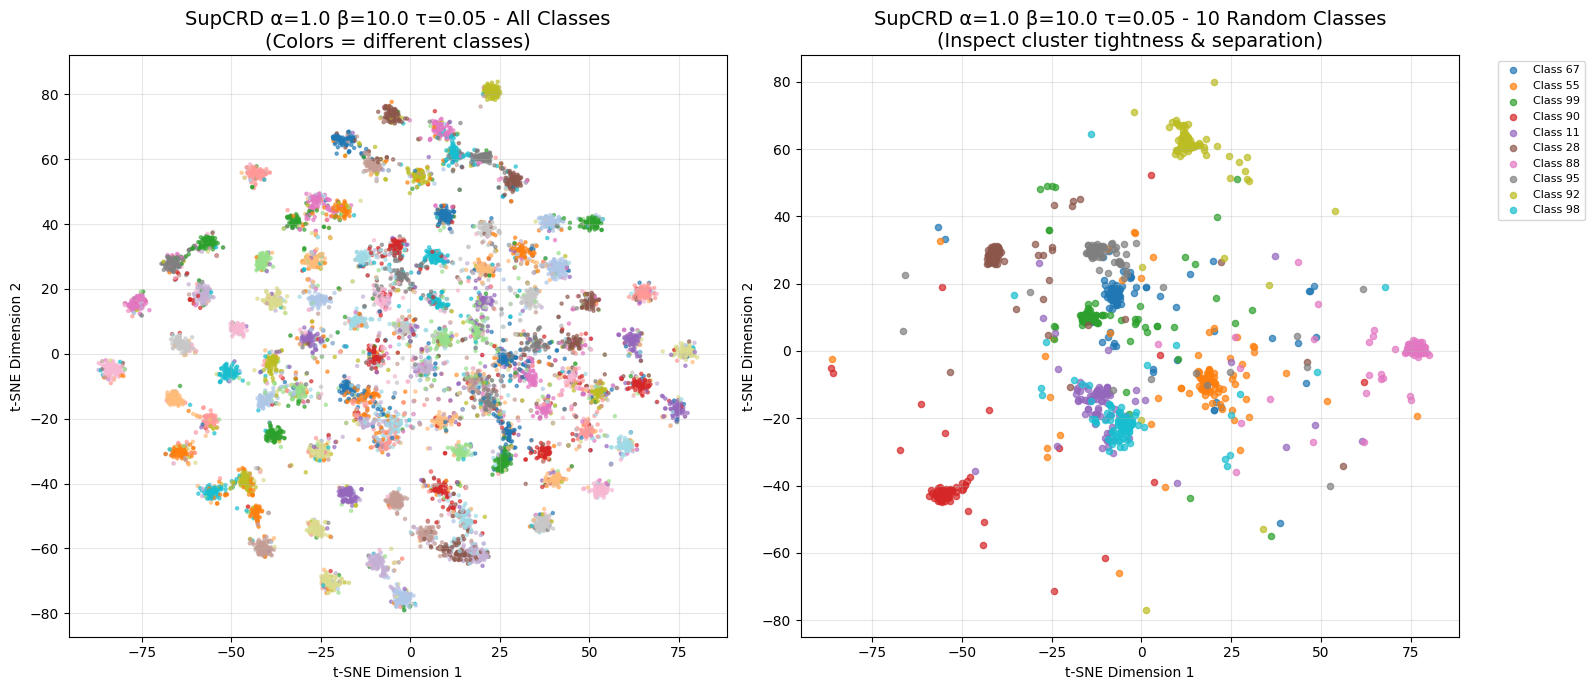


HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.5007
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9609
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 1.9190
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 275.24it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:00<00:00, 154.39it/s]
/tmp/ipykernel_30646/2628682699.py:290: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Computing uniformity (angular distribution)...
✓ Saved to plots/temp_0.05_alignment.png


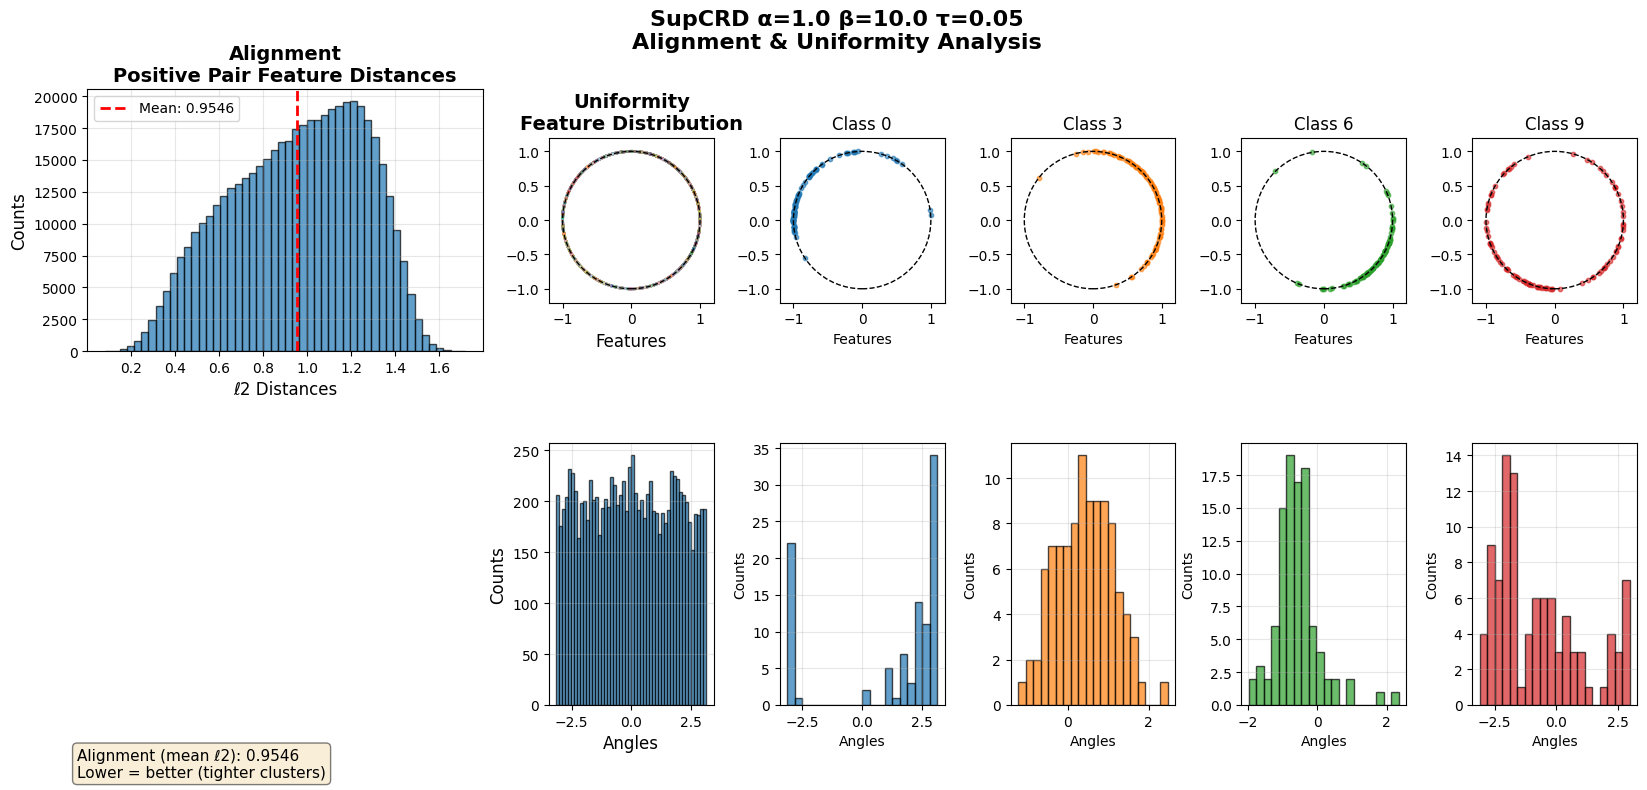


ALIGNMENT & UNIFORMITY METRICS
Alignment (positive pair ℓ2 distance):
  Mean: 0.9546
  Std:  0.3003
  → Lower = better (tighter clusters)

Uniformity (angular coverage):
  Angle std: 1.7970
  → Higher = better (more uniform distribution)


Extracting: 100%|██████████| 79/79 [00:00<00:00, 265.80it/s]



Wang & Isola Metrics:
  Alignment loss (t=2): 1.0014 (lower = better)
  Uniformity loss (t=2): -3.6787 (lower = better)
  Intra-class: 0.5007 | Inter-class: 0.9609
  Alignment: 1.0014 | Uniformity: -3.6787

Loading alpha_1.0_beta_10.0_temp_0.07 from cache
τ=0.07: Train=99.332%, Test=71.63%

📊 Visualizing τ=0.07...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


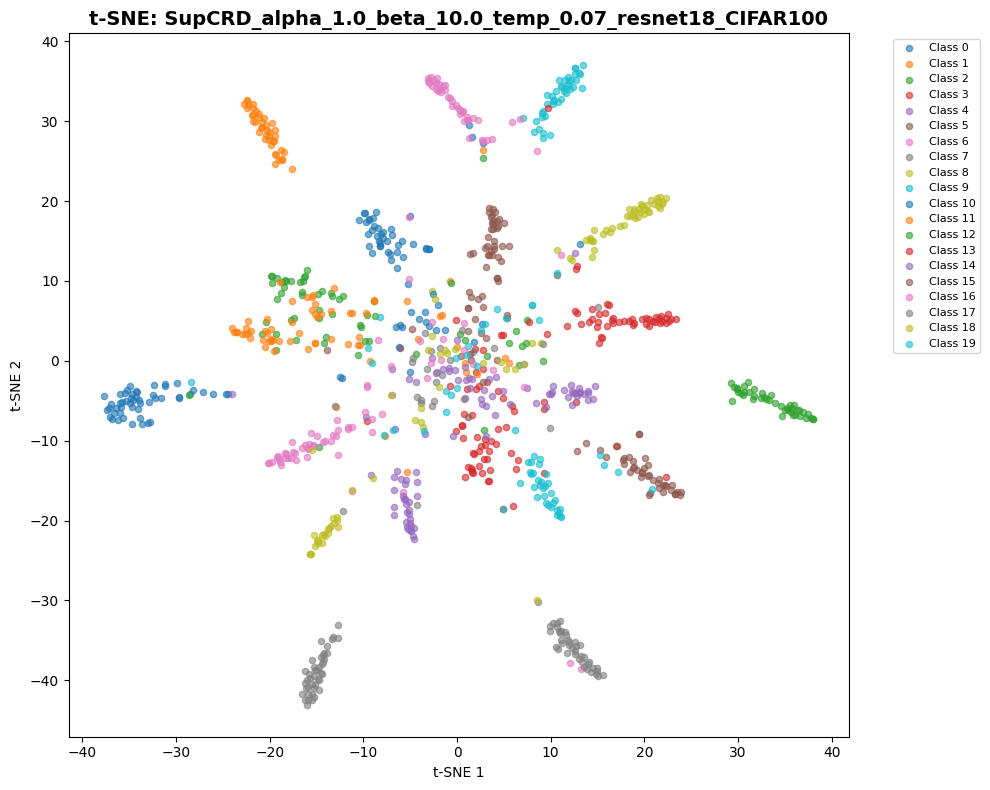

✓ τ=0.07 visualization complete


📊 Quality Analysis for τ=0.07...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 280.25it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running t-SNE (this may take a minute)...
✓ Saved to plots/temp_0.07_hypersphere.png


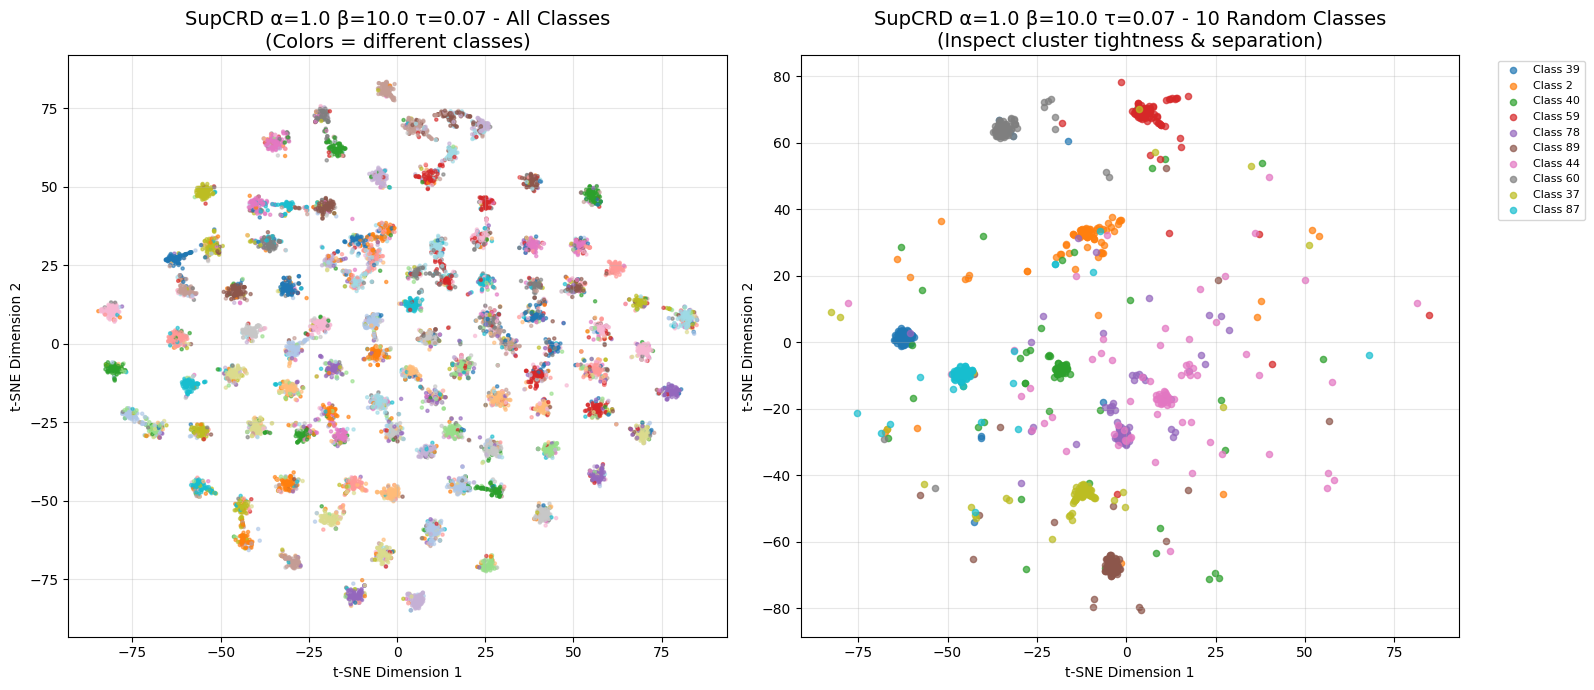


HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.4217
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9880
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 2.3428
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 266.07it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:00<00:00, 159.25it/s]


Computing uniformity (angular distribution)...


/tmp/ipykernel_30646/2628682699.py:290: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Saved to plots/temp_0.07_alignment.png


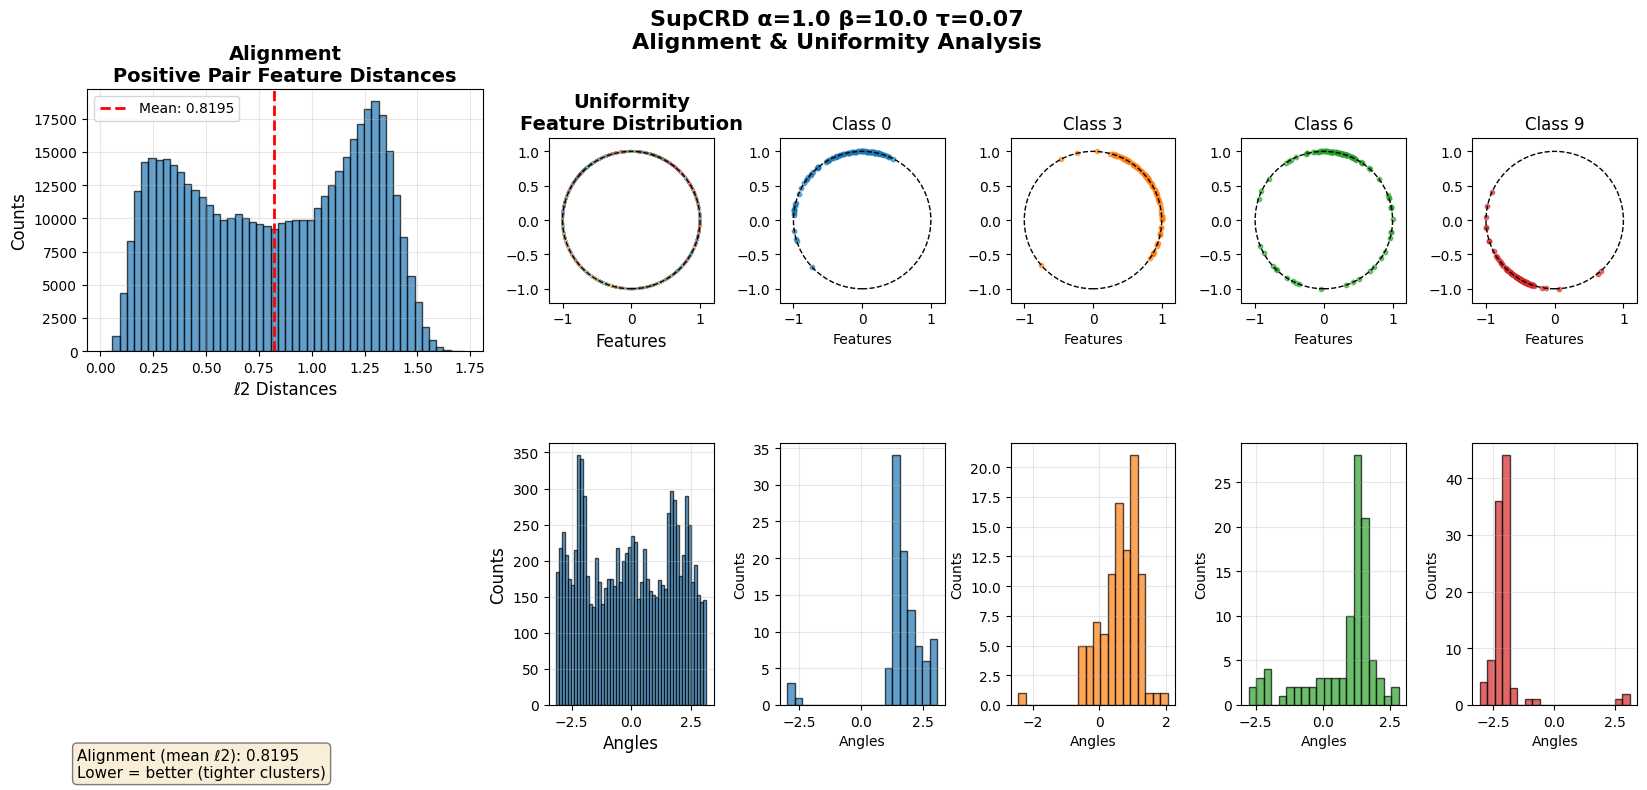


ALIGNMENT & UNIFORMITY METRICS
Alignment (positive pair ℓ2 distance):
  Mean: 0.8195
  Std:  0.4144
  → Lower = better (tighter clusters)

Uniformity (angular coverage):
  Angle std: 1.8346
  → Higher = better (more uniform distribution)


Extracting: 100%|██████████| 79/79 [00:00<00:00, 293.37it/s]


Wang & Isola Metrics:
  Alignment loss (t=2): 0.8434 (lower = better)
  Uniformity loss (t=2): -3.6097 (lower = better)
  Intra-class: 0.4217 | Inter-class: 0.9880
  Alignment: 0.8434 | Uniformity: -3.6097


TEMPERATURE SWEEP SUMMARY (α=1.0, β=10.0)
τ= 0.05: Test=72.28% (Δ=+3.20%)
τ= 0.07: Test=71.63% (Δ=+2.55%)



In [15]:
FORCE_RETRAIN_TEMP_SWEEP = False

temp_results = {}
for temp_val in TEMP_SWEEP:
    exp_name = f'alpha_1.0_beta_10.0_temp_{temp_val}'
    model_path = f'pth_models/student_{exp_name}_{STUDENT_ARCH}_cifar100.pth'
    
    log = load_training_log(f'{exp_name}_{STUDENT_ARCH}_cifar100')
    if os.path.exists(model_path) and not FORCE_RETRAIN_TEMP_SWEEP and log:
        print(f"Loading {exp_name} from cache")
        student = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(device)
        student.load_state_dict(torch.load(model_path, map_location=device))
        train_acc = log['train_acc'][-1]
    else:
        student = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=LR)
        criterion = LogitWeightedSupCRDLoss(alpha=1.0, beta=10.0, temperature=temp_val)
        student, log = train_student(
            teacher, student, train_loader, optimizer, criterion, device,
            epochs=EPOCHS_STUDENT, label=f'SupCRD_τ={temp_val}', mode='supcrd',
            log_name=f'{exp_name}_{STUDENT_ARCH}_cifar100'
        )
        torch.save(student.state_dict(), model_path)
        train_acc = log['train_acc'][-1]
    
    test_acc = evaluate_model(student, test_loader, device)
    temp_results[temp_val] = {'train': train_acc, 'test': test_acc}
    print(f"τ={temp_val}: Train={train_acc}%, Test={test_acc}%\n")
    
    # Visualize this temperature config
    print(f"📊 Visualizing τ={temp_val}...")
    visualize_latents(student, test_loader, device,
        title=f"SupCRD_alpha_1.0_beta_10.0_temp_{temp_val}_{STUDENT_ARCH}_CIFAR100",
        sample_classes=sample_classes)
    print(f"✓ τ={temp_val} visualization complete\n")
    
    # Quality analysis
    print(f"\n📊 Quality Analysis for τ={temp_val}...")
    metrics_hyper = visualize_hypersphere_distribution(
        student, test_loader, device,
        title=f"SupCRD α=1.0 β=10.0 τ={temp_val}",
        save_path=f"plots/temp_{temp_val}_hypersphere.png"
    )
    metrics_align = visualize_alignment_uniformity(
        student, test_loader, device,
        title=f"SupCRD α=1.0 β=10.0 τ={temp_val}",
        save_path=f"plots/temp_{temp_val}_alignment.png"
    )
    # Wang & Isola metrics
    all_proj, all_lab = [], []
    student.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Extracting"):
            images = images.to(device)
            features = student.encoder(images)
            proj = F.normalize(student.projector(features), dim=1)
            all_proj.append(proj.cpu())
            all_lab.append(labels)
    proj_tensor = torch.cat(all_proj, dim=0)
    lab_tensor = torch.cat(all_lab, dim=0)
    align_loss, uniform_loss = compute_alignment_uniformity_loss(proj_tensor, lab_tensor, t_align=2, t_uniform=2)
    print(f"  Intra-class: {metrics_hyper['intra_class_dist']:.4f} | Inter-class: {metrics_hyper['inter_class_dist']:.4f}")
    print(f"  Alignment: {align_loss:.4f} | Uniformity: {uniform_loss:.4f}\n")

# Summary
print(f"\n{'='*60}")
print(f"TEMPERATURE SWEEP SUMMARY (α=1.0, β=10.0)")
print(f"{'='*60}")
for temp_val, res in temp_results.items():
    delta = res['test'] - acc_baseline
    print(f"τ={temp_val:5.2f}: Test={res['test']:5.2f}% (Δ={delta:+.2f}%)")
print(f"{'='*60}\n")

---
## EXPERIMENT 6: Semantic Similarity Analysis

Compare semantic structure for selected class pairs

In [16]:
# Define representative class pairs for CIFAR-100
# Format: (class1_idx, class2_idx, description)
class_pairs = [
    (3, 42, "baby-boy (similar)"),
    (3, 99, "baby-worm (dissimilar)"),
    (4, 55, "bear-otter (similar mammals)"),
    (4, 8, "bear-bicycle (dissimilar)"),
    (11, 35, "boy-girl (similar)"),
    (11, 90, "boy-tulip (dissimilar)"),
]

print("\n" + "="*80)
print("SEMANTIC SIMILARITY COMPARISON")
print("="*80)

# Analyze baseline
baseline_sim = analyze_similarity(
    student_baseline, test_loader, device, 
    class_pairs, title="Baseline SupCon"
)

# Analyze best SupCRD (choose best from sweeps)
best_alpha = max(alpha_results.items(), key=lambda x: x[1]['test'])[0]
best_supcrd_path = f'pth_models/student_alpha_{best_alpha}_beta_1.0_{STUDENT_ARCH}_cifar100.pth'
if os.path.exists(best_supcrd_path):
    student_best = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(device)
    student_best.load_state_dict(torch.load(best_supcrd_path, map_location=device))
    best_sim = analyze_similarity(
        student_best, test_loader, device,
        class_pairs, title=f"SupCRD (α={best_alpha}, β=1)"
    )


SEMANTIC SIMILARITY COMPARISON

Semantic Similarity Analysis: Baseline SupCon
  baby-boy (similar)            : 0.651
  baby-worm (dissimilar)        : 0.423
  bear-otter (similar mammals)  : 0.929
  bear-bicycle (dissimilar)     : 0.323
  boy-girl (similar)            : 0.964
  boy-tulip (dissimilar)        : 0.234


Semantic Similarity Analysis: SupCRD (α=1.0, β=1)
  baby-boy (similar)            : 0.197
  baby-worm (dissimilar)        : -0.094
  bear-otter (similar mammals)  : 0.472
  bear-bicycle (dissimilar)     : -0.041
  boy-girl (similar)            : 0.766
  boy-tulip (dissimilar)        : 0.107



---
## EXPERIMENT 7: Hybrid Loss

Loading hybrid_lambda_0.3 from cache
λ=0.3: Train=99.32%, Test=71.17%

📊 Visualizing λ=0.3...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


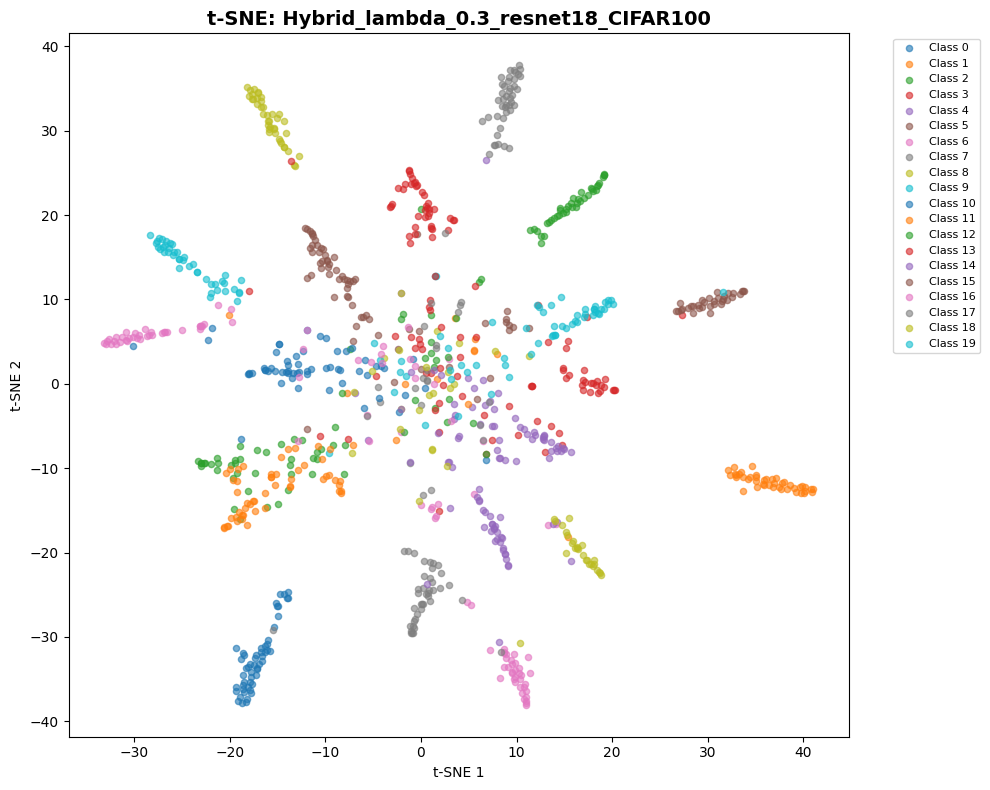

✓ λ=0.3 visualization complete


📊 Quality Analysis for λ=0.3...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 276.68it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running t-SNE (this may take a minute)...
✓ Saved to plots/hybrid_lambda_0.3_hypersphere.png


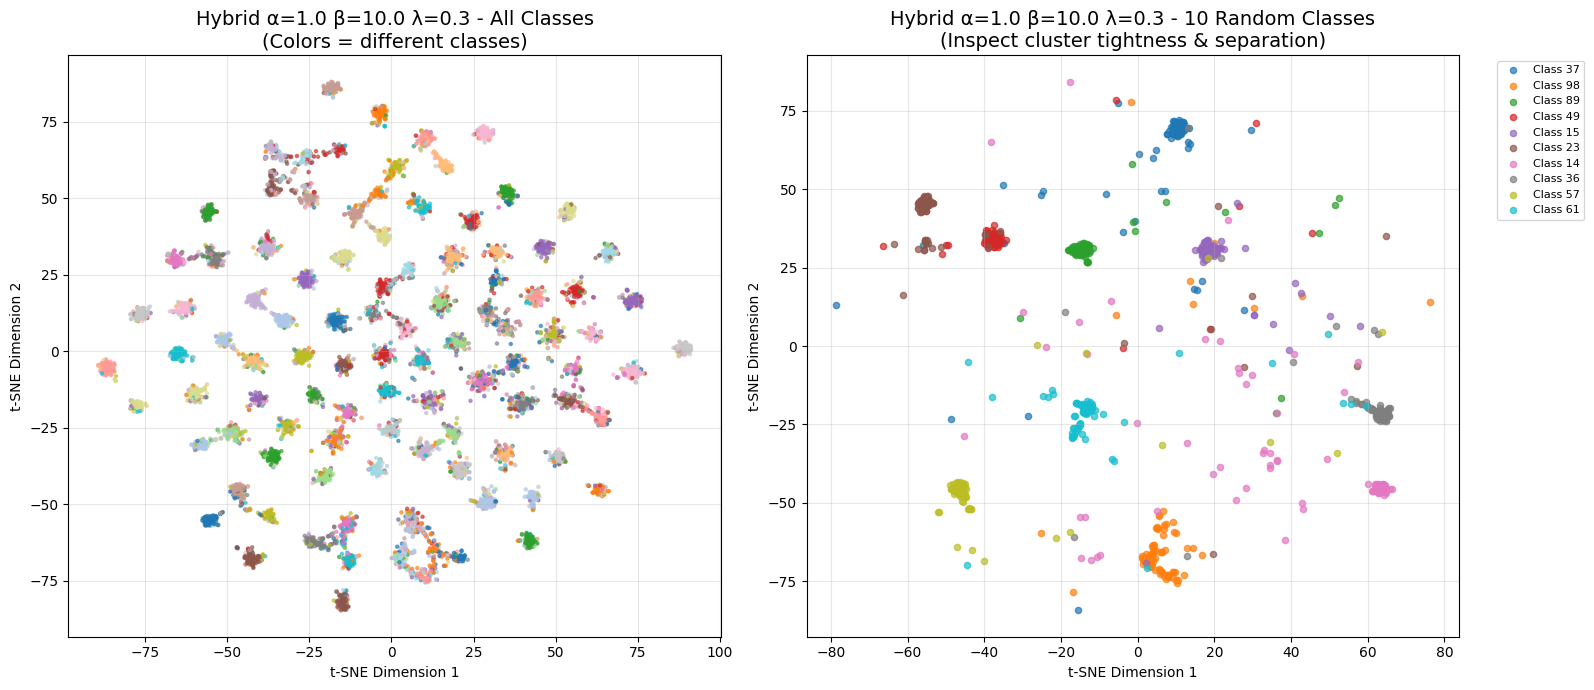


HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.3682
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9819
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 2.6666
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 273.78it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:00<00:00, 161.49it/s]
/tmp/ipykernel_30646/2628682699.py:290: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Computing uniformity (angular distribution)...
✓ Saved to plots/hybrid_lambda_0.3_alignment.png


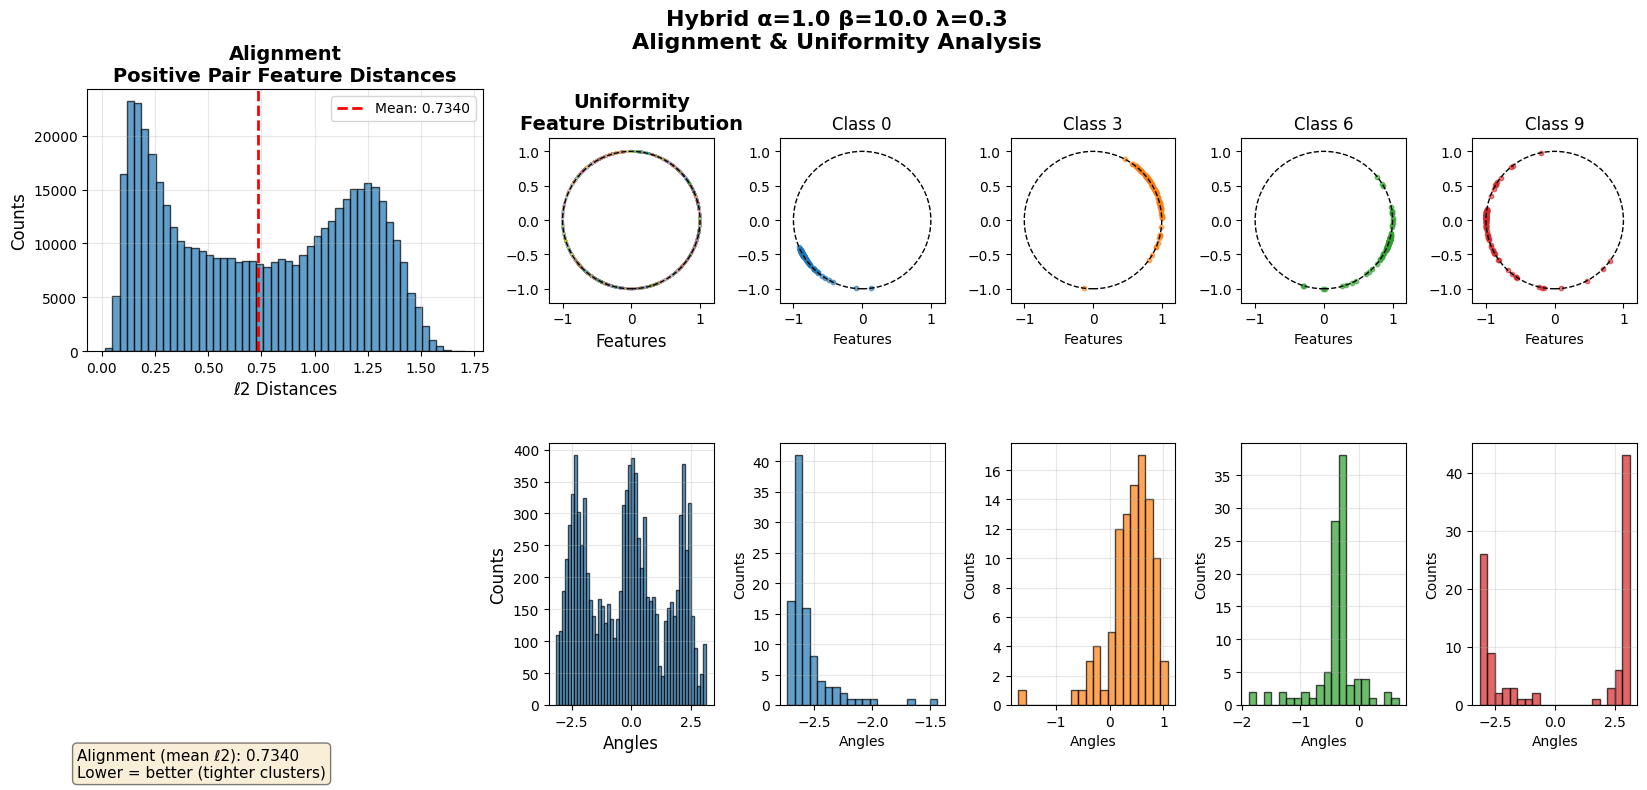


ALIGNMENT & UNIFORMITY METRICS
Alignment (positive pair ℓ2 distance):
  Mean: 0.7340
  Std:  0.4446
  → Lower = better (tighter clusters)

Uniformity (angular coverage):
  Angle std: 1.7268
  → Higher = better (more uniform distribution)


Extracting: 100%|██████████| 79/79 [00:00<00:00, 267.85it/s]



Wang & Isola Metrics:
  Alignment loss (t=2): 0.7364 (lower = better)
  Uniformity loss (t=2): -3.5235 (lower = better)
  Intra-class: 0.3682 | Inter-class: 0.9819
  Alignment: 0.7364 | Uniformity: -3.5235

Loading hybrid_lambda_0.5 from cache
λ=0.5: Train=99.2%, Test=70.89%

📊 Visualizing λ=0.5...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


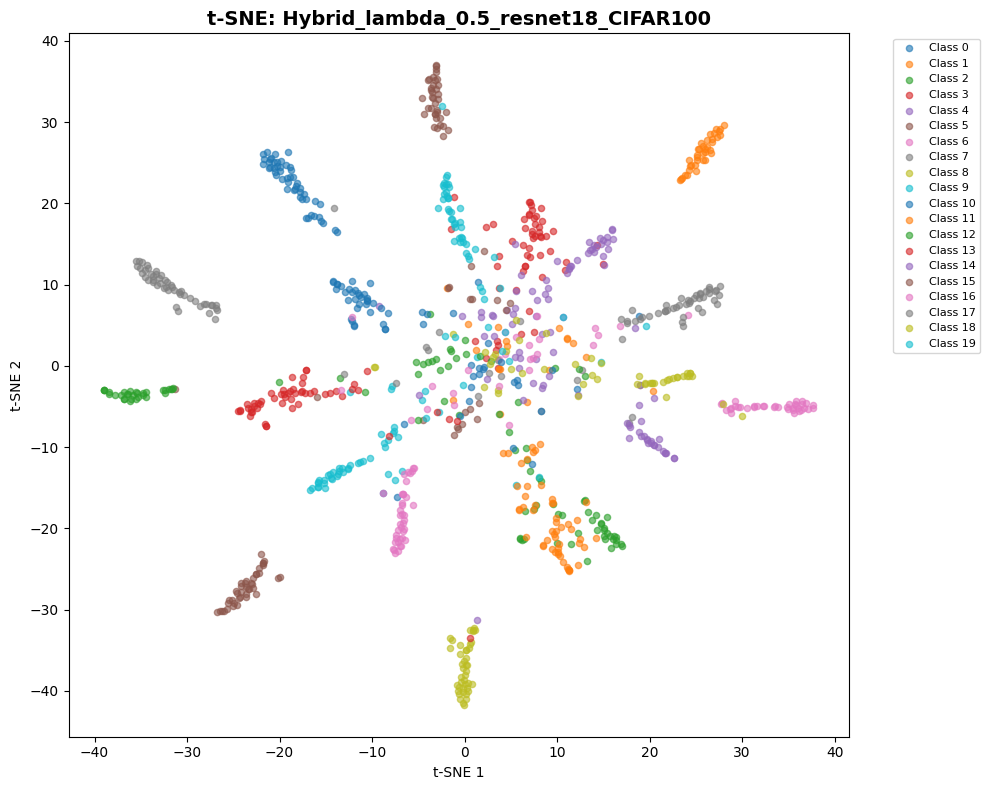

✓ λ=0.5 visualization complete


📊 Quality Analysis for λ=0.5...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 265.76it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running t-SNE (this may take a minute)...
✓ Saved to plots/hybrid_lambda_0.5_hypersphere.png


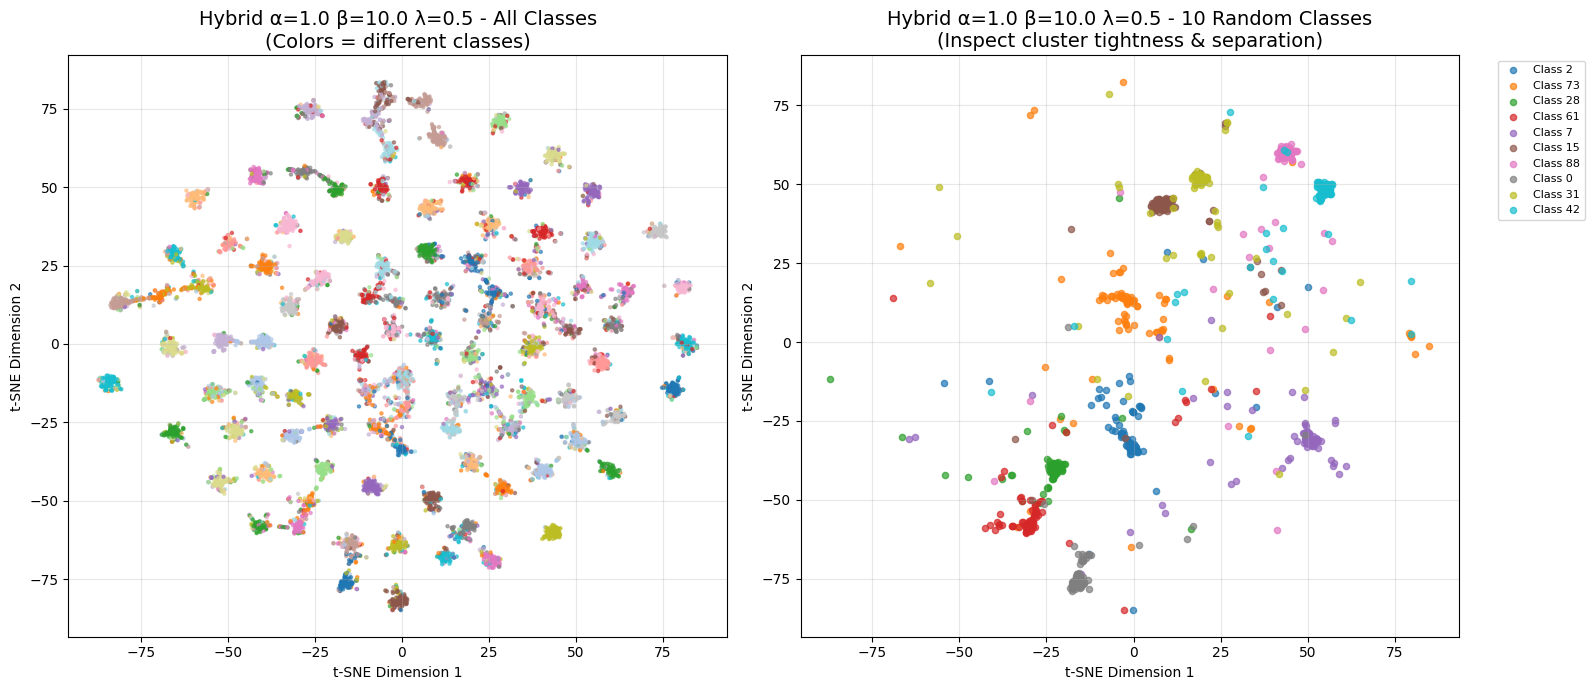


HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.3228
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.9063
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 2.8074
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 274.78it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:00<00:00, 160.68it/s]


Computing uniformity (angular distribution)...


/tmp/ipykernel_30646/2628682699.py:290: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Saved to plots/hybrid_lambda_0.5_alignment.png


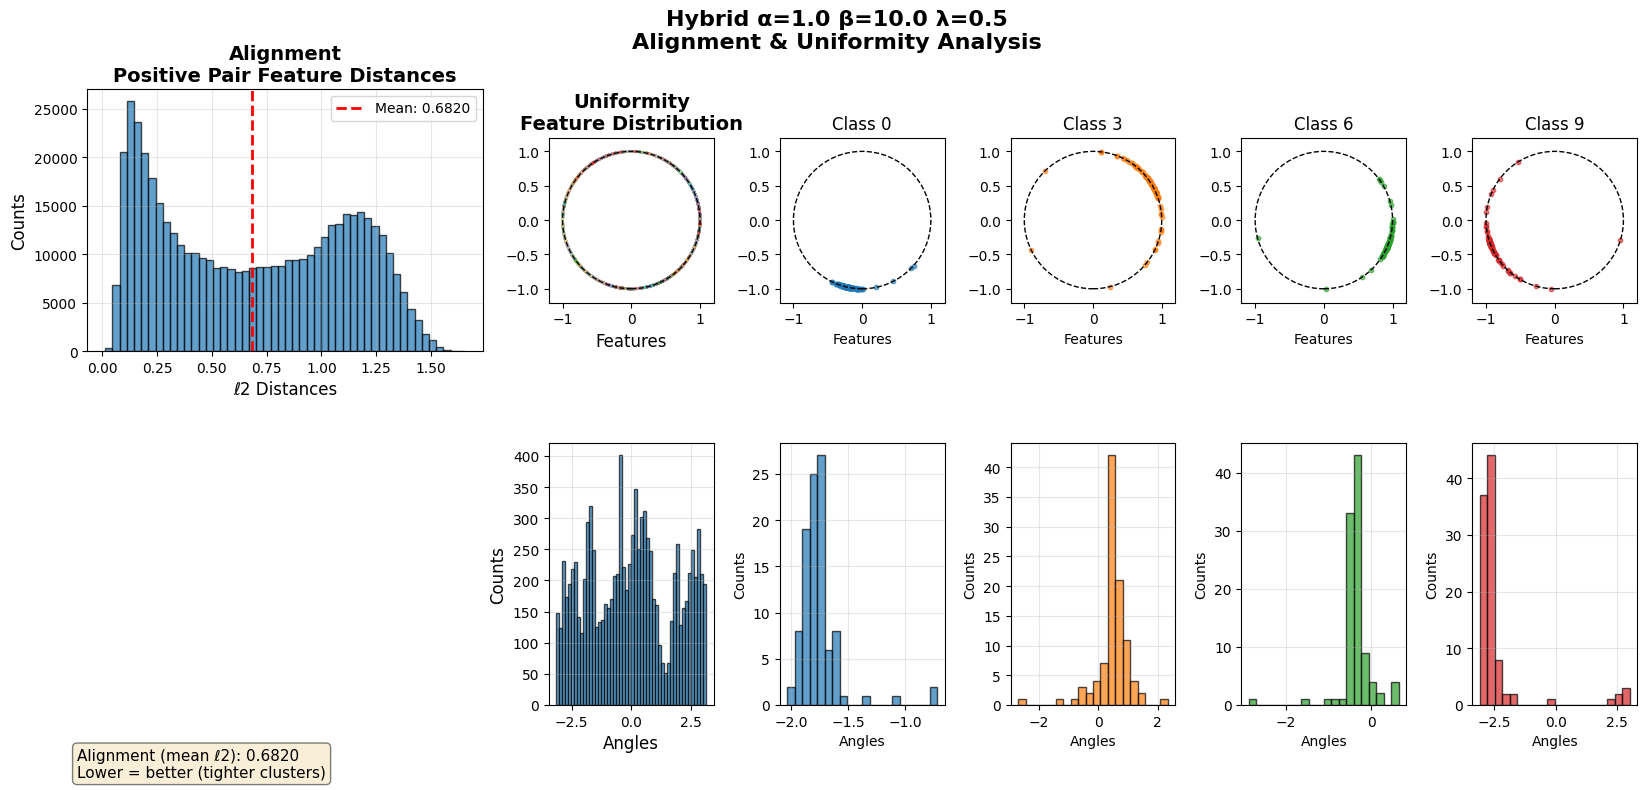


ALIGNMENT & UNIFORMITY METRICS
Alignment (positive pair ℓ2 distance):
  Mean: 0.6820
  Std:  0.4249
  → Lower = better (tighter clusters)

Uniformity (angular coverage):
  Angle std: 1.7696
  → Higher = better (more uniform distribution)


Extracting: 100%|██████████| 79/79 [00:00<00:00, 272.21it/s]



Wang & Isola Metrics:
  Alignment loss (t=2): 0.6457 (lower = better)
  Uniformity loss (t=2): -3.3013 (lower = better)
  Intra-class: 0.3228 | Inter-class: 0.9063
  Alignment: 0.6457 | Uniformity: -3.3013

Loading hybrid_lambda_0.7 from cache
λ=0.7: Train=98.666%, Test=70.52%

📊 Visualizing λ=0.7...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


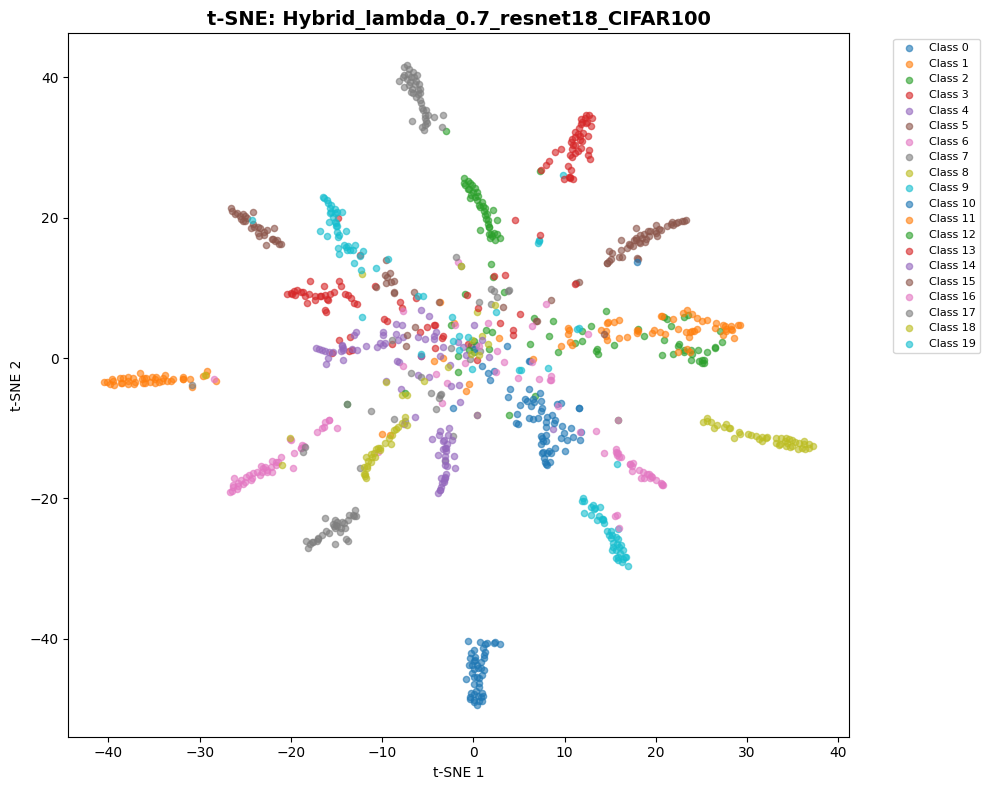

✓ λ=0.7 visualization complete


📊 Quality Analysis for λ=0.7...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 265.72it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running t-SNE (this may take a minute)...
✓ Saved to plots/hybrid_lambda_0.7_hypersphere.png


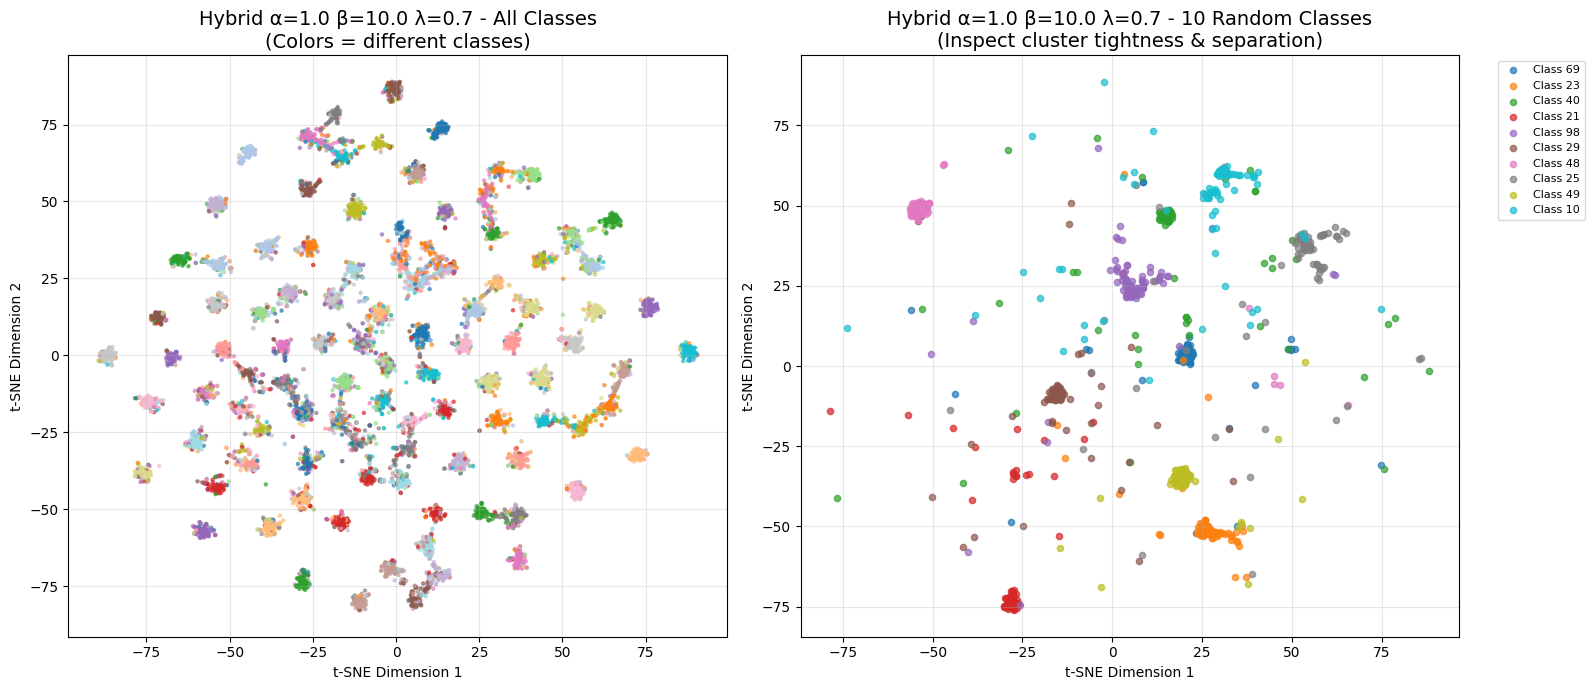


HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.2841
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.7883
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 2.7750
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 273.61it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:00<00:00, 154.96it/s]
/tmp/ipykernel_30646/2628682699.py:290: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Computing uniformity (angular distribution)...
✓ Saved to plots/hybrid_lambda_0.7_alignment.png


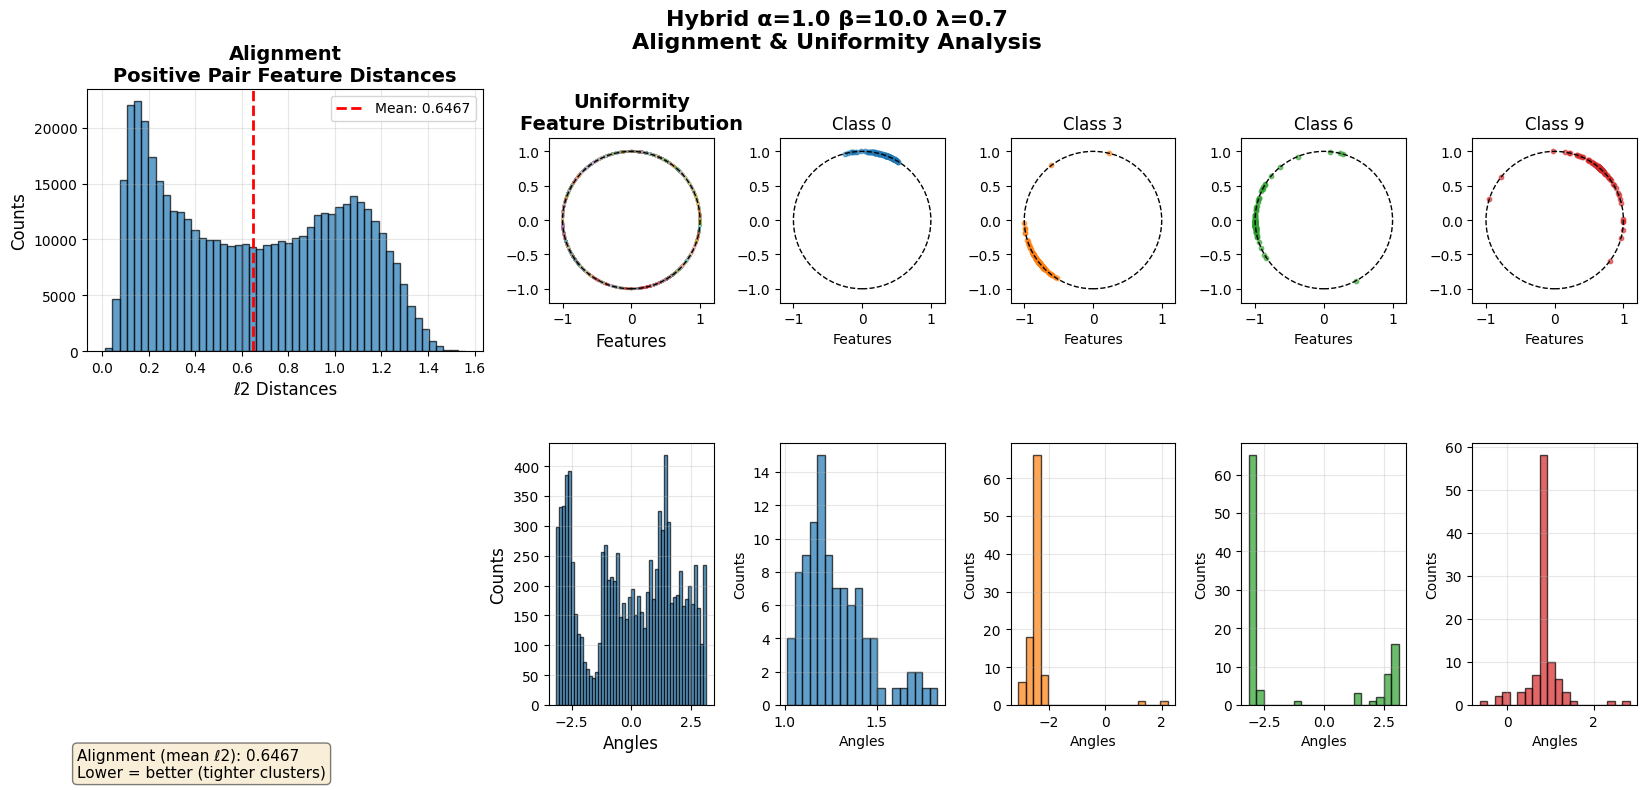


ALIGNMENT & UNIFORMITY METRICS
Alignment (positive pair ℓ2 distance):
  Mean: 0.6467
  Std:  0.3871
  → Lower = better (tighter clusters)

Uniformity (angular coverage):
  Angle std: 1.8901
  → Higher = better (more uniform distribution)


Extracting: 100%|██████████| 79/79 [00:00<00:00, 282.31it/s]



Wang & Isola Metrics:
  Alignment loss (t=2): 0.5682 (lower = better)
  Uniformity loss (t=2): -3.0593 (lower = better)
  Intra-class: 0.2841 | Inter-class: 0.7883
  Alignment: 0.5682 | Uniformity: -3.0593

Loading hybrid_lambda_0.9 from cache
λ=0.9: Train=95.82%, Test=70.98%

📊 Visualizing λ=0.9...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


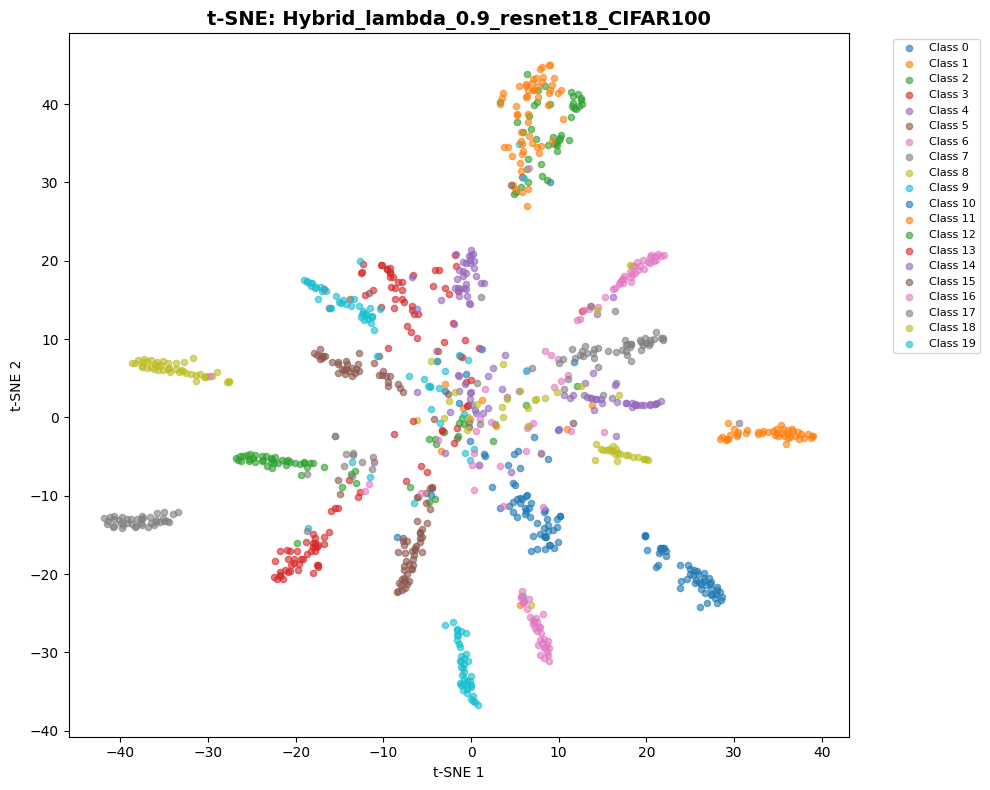

✓ λ=0.9 visualization complete


📊 Quality Analysis for λ=0.9...
Extracting projections from test set...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 265.44it/s]


Projections shape: (10000, 64)
Projection norms (should be ~1.0): min=1.0000, max=1.0000
Running t-SNE (this may take a minute)...
✓ Saved to plots/hybrid_lambda_0.9_hypersphere.png


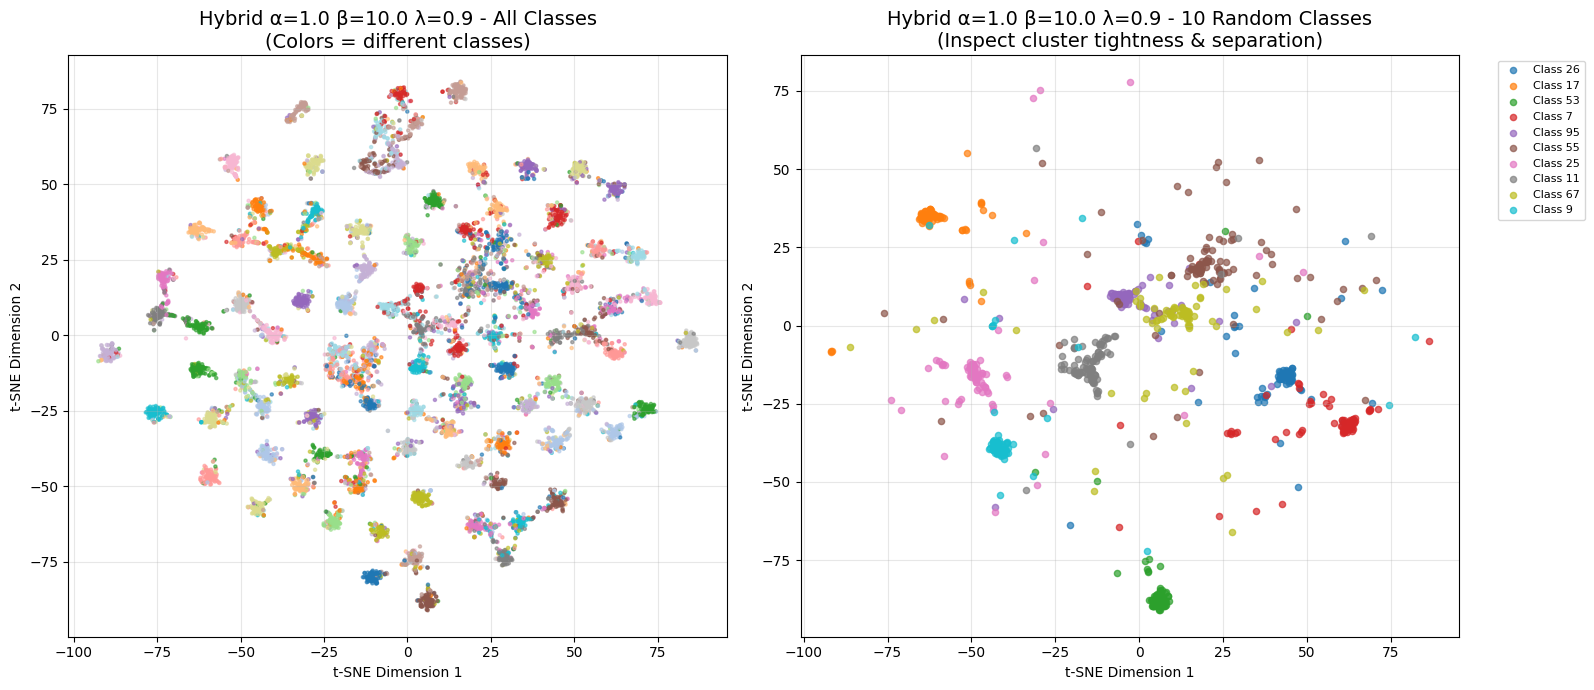


HYPERSPHERE DISTRIBUTION METRICS
Avg Intra-Class Distance (cosine): 0.2368
  → Lower = better ALIGNMENT (tight clusters)

Avg Inter-Class Distance (cosine): 0.6880
  → Higher = better UNIFORMITY (well separated)

Separation Ratio (inter/intra): 2.9055
  → Higher = better overall (clear clusters)
Extracting projections for alignment/uniformity analysis...


Extracting: 100%|██████████| 79/79 [00:00<00:00, 263.80it/s]


Projections shape: (10000, 64)
Computing alignment (positive pair distances)...


Alignment: 100%|██████████| 100/100 [00:00<00:00, 159.95it/s]


Computing uniformity (angular distribution)...


/tmp/ipykernel_30646/2628682699.py:290: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Saved to plots/hybrid_lambda_0.9_alignment.png


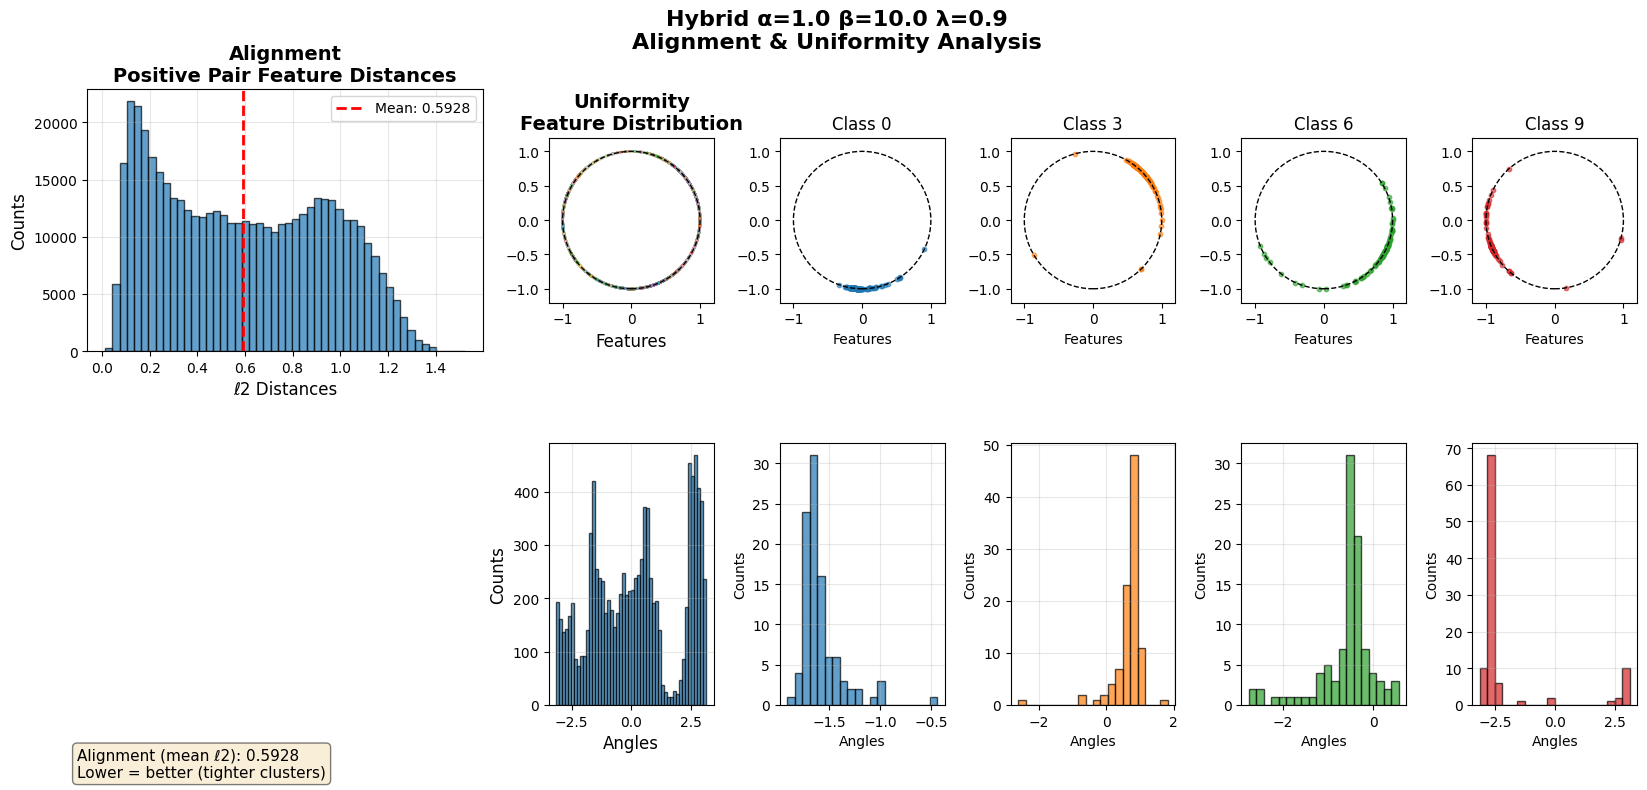


ALIGNMENT & UNIFORMITY METRICS
Alignment (positive pair ℓ2 distance):
  Mean: 0.5928
  Std:  0.3496
  → Lower = better (tighter clusters)

Uniformity (angular coverage):
  Angle std: 1.8467
  → Higher = better (more uniform distribution)


Extracting: 100%|██████████| 79/79 [00:00<00:00, 278.00it/s]


Wang & Isola Metrics:
  Alignment loss (t=2): 0.4736 (lower = better)
  Uniformity loss (t=2): -2.6881 (lower = better)
  Intra-class: 0.2368 | Inter-class: 0.6880
  Alignment: 0.4736 | Uniformity: -2.6881


HYBRID LOSS SUMMARY (α=1.0, β=10.0, τ=0.07)
λ= 0.30: Test=71.17% (Δ=+2.09%)
λ= 0.50: Test=70.89% (Δ=+1.81%)
λ= 0.70: Test=70.52% (Δ=+1.44%)
λ= 0.90: Test=70.98% (Δ=+1.90%)



In [17]:
FORCE_RETRAIN_HYBRID = False
RUN_HYBRID_EXPERIMENTS = True  # Set to True to run hybrid experiments

if RUN_HYBRID_EXPERIMENTS:
    hybrid_results = {}
    for lambda_val in LAMBDA_SWEEP:
        exp_name = f"hybrid_lambda_{lambda_val}"
        model_path = f"pth_models/student_{exp_name}_{STUDENT_ARCH}_cifar100.pth"

        log = load_training_log(f"{exp_name}_{STUDENT_ARCH}_cifar100")
        if os.path.exists(model_path) and not FORCE_RETRAIN_HYBRID and log:
            print(f"Loading {exp_name} from cache")
            student = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(
                device
            )
            student.load_state_dict(torch.load(model_path, map_location=device))
            train_acc = log["train_acc"][-1]
        else:
            student = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(
                device
            )
            optimizer = torch.optim.Adam(student.parameters(), lr=LR)
            criterion = HybridSupCRDLoss(
                alpha=1.0, beta=10.0, lambda_supcon=lambda_val, temperature=TEMP
            )
            student, log = train_student(
                teacher,
                student,
                train_loader,
                optimizer,
                criterion,
                device,
                epochs=EPOCHS_STUDENT,
                label=f"Hybrid_λ={lambda_val}",
                mode="hybrid",
                log_name=f"{exp_name}_{STUDENT_ARCH}_cifar100",
            )
            torch.save(student.state_dict(), model_path)
            train_acc = log["train_acc"][-1]

        test_acc = evaluate_model(student, test_loader, device)
        hybrid_results[lambda_val] = {"train": train_acc, "test": test_acc}
        print(f"λ={lambda_val}: Train={train_acc}%, Test={test_acc}%\n")

        # Visualize this hybrid config
        print(f"📊 Visualizing λ={lambda_val}...")
        visualize_latents(
            student,
            test_loader,
            device,
            title=f"Hybrid_lambda_{lambda_val}_{STUDENT_ARCH}_CIFAR100",
            sample_classes=sample_classes,
        )
        print(f"✓ λ={lambda_val} visualization complete\n")
        
        # Quality analysis
        print(f"\n📊 Quality Analysis for λ={lambda_val}...")
        metrics_hyper = visualize_hypersphere_distribution(
            student, test_loader, device,
            title=f"Hybrid α=1.0 β=10.0 λ={lambda_val}",
            save_path=f"plots/hybrid_lambda_{lambda_val}_hypersphere.png"
        )
        metrics_align = visualize_alignment_uniformity(
            student, test_loader, device,
            title=f"Hybrid α=1.0 β=10.0 λ={lambda_val}",
            save_path=f"plots/hybrid_lambda_{lambda_val}_alignment.png"
        )
        # Wang & Isola metrics
        all_proj, all_lab = [], []
        student.eval()
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Extracting"):
                images = images.to(device)
                features = student.encoder(images)
                proj = F.normalize(student.projector(features), dim=1)
                all_proj.append(proj.cpu())
                all_lab.append(labels)
        proj_tensor = torch.cat(all_proj, dim=0)
        lab_tensor = torch.cat(all_lab, dim=0)
        align_loss, uniform_loss = compute_alignment_uniformity_loss(proj_tensor, lab_tensor, t_align=2, t_uniform=2)
        print(f"  Intra-class: {metrics_hyper['intra_class_dist']:.4f} | Inter-class: {metrics_hyper['inter_class_dist']:.4f}")
        print(f"  Alignment: {align_loss:.4f} | Uniformity: {uniform_loss:.4f}\n")

    # Summary
    print(f"\n{'='*60}")
    print(f"HYBRID LOSS SUMMARY (α=1.0, β=10.0, τ={TEMP})")
    print(f"{'='*60}")
    for lambda_val, res in hybrid_results.items():
        delta = res["test"] - acc_baseline
        print(f"λ={lambda_val:5.2f}: Test={res['test']:5.2f}% (Δ={delta:+.2f}%)")
    print(f"{'='*60}\n")
else:
    print("Skipping hybrid experiments (RUN_HYBRID_EXPERIMENTS=False)")

---
## Final Summary & Export Results

In [18]:
# Compile comprehensive results
comprehensive_results = {
    'config': {
        'dataset': 'CIFAR-100',
        'teacher_arch': TEACHER_ARCH,
        'student_arch': STUDENT_ARCH,
        'epochs_teacher': EPOCHS_TEACHER,
        'epochs_student': EPOCHS_STUDENT,
        'batch_size': BATCH_SIZE,
        'lr': LR,
        'temperature': TEMP,
    },
    'teacher': {
        'test_acc': acc_teacher,
    },
    'baseline_supcon': {
        'test_acc': acc_baseline,
    },
    'alpha_sweep': alpha_results,
    'beta_sweep': beta_results,
    'temp_sweep': temp_results,
}

if RUN_HYBRID_EXPERIMENTS:
    comprehensive_results['hybrid_sweep'] = hybrid_results

# Save to JSON
results_path = f'json_results/comprehensive_results_{STUDENT_ARCH}_cifar100.json'
with open(results_path, 'w') as f:
    json.dump(comprehensive_results, f, indent=2)

print(f"\n{'='*70}")
print(f"FINAL SUMMARY - CIFAR-100")
print(f"{'='*70}")
print(f"Architecture: Teacher={TEACHER_ARCH.upper()}, Student={STUDENT_ARCH.upper()}")
print(f"Teacher:        {acc_teacher:.2f}%")
print(f"Baseline:       {acc_baseline:.2f}%")
print(f"\nBest α config:  {max(alpha_results.items(), key=lambda x: x[1]['test'])[0]} → {max(alpha_results.values(), key=lambda x: x['test'])['test']:.2f}%")
print(f"Best β config:  {max(beta_results.items(), key=lambda x: x[1]['test'])[0]} → {max(beta_results.values(), key=lambda x: x['test'])['test']:.2f}%")
print(f"Best τ config:  {max(temp_results.items(), key=lambda x: x[1]['test'])[0]} → {max(temp_results.values(), key=lambda x: x['test'])['test']:.2f}%")
print(f"\nResults saved to: {results_path}")
print(f"{'='*70}\n")


FINAL SUMMARY - CIFAR-100
Architecture: Teacher=RESNET50, Student=RESNET18
Teacher:        80.75%
Baseline:       69.08%

Best α config:  1.0 → 72.30%
Best β config:  1.0 → 72.30%
Best τ config:  0.05 → 72.28%

Results saved to: json_results/comprehensive_results_resnet18_cifar100.json

